# Merge Multimodal data and convert categorical and remove date columns


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

# Load the first dataset
file1_path = 'cognid_scans_cleaned.xlsx'
cognid_df = pd.read_excel(file1_path)
print(f"Loaded cognid_scans_cleaned.xlsx with {cognid_df.shape[0]} rows and {cognid_df.shape[1]} columns")

# Load the second dataset - replace 'other_data.csv' with your actual file path
file2_path = 'cognid_with_risk_scores_cleaned.xlsx'  # your file with cognitive assessment and risk scores
other_df = pd.read_excel(file2_path)  # Or pd.read_excel() if it's an Excel file
print(f"Loaded second dataset with {other_df.shape[0]} rows and {other_df.shape[1]} columns")

# Create a mapping column in cognid_df that strips out characters after underscore
cognid_df['MRI_ID_Base'] = cognid_df['MRI_ID'].apply(lambda x: x.split('_')[0] if isinstance(x, str) and '_' in x else x)

# Print some examples of the mapping for verification
print("\nExample MRI_ID mappings:")
sample_ids = cognid_df[['MRI_ID', 'MRI_ID_Base']].head(10)
print(sample_ids)

# Rename the 'Study Number' column in the second dataframe to match our base ID column
other_df = other_df.rename(columns={'Study Number': 'MRI_ID_Base'})

# Function to convert text-based yes/no values to numeric (1/0)
def convert_yes_no(value):
    if pd.isna(value):
        return value
    
    if isinstance(value, str):
        # Convert to lowercase for case-insensitive comparison
        value = value.lower()
        if value in ['yes', 'y']:
            return 1
        elif value in ['no', 'n']:
            return 0
    return value

# Function to detect date columns
def is_date_column(series):
    # Check if the column name suggests a date
    if any(date_key in series.name.lower() for date_key in ['date', 'time', 'day', 'month', 'year', 'dob']):
        return True
    
    # Check if the dtype is already a datetime
    if pd.api.types.is_datetime64_dtype(series):
        return True
    
    # For string columns, check if values look like dates
    if series.dtype == 'object':
        # Get non-null values
        non_null = series.dropna()
        if len(non_null) == 0:
            return False
            
        # Sample values to check
        sample = non_null.sample(min(10, len(non_null)))
        date_patterns = 0
        
        for val in sample:
            if not isinstance(val, str):
                continue
                
            # Check common date patterns
            if any(char in val for char in ['/', '-', '.']):  # Date separators
                date_patterns += 1
        
        # If most samples have date patterns
        if date_patterns >= len(sample) * 0.7:
            return True
    
    return False

# Convert categorical yes/no columns in both datasets
print("\nConverting categorical yes/no data to numeric...")

# Process cognid_df - identify object columns that might be categorical
for col in cognid_df.select_dtypes(include=['object']).columns:
    # Skip ID columns
    if 'id' in col.lower() or 'diagnos' in col.lower():
        continue
    
    # Check if the column has yes/no values
    unique_vals = cognid_df[col].dropna().astype(str).str.lower().unique()
    has_yes_no = any(val in ['yes', 'y', 'no', 'n'] for val in unique_vals)
    
    if has_yes_no:
        print(f"Converting column: {col}")
        cognid_df[col] = cognid_df[col].apply(convert_yes_no)

# Process other_df - identify object columns that might be categorical
for col in other_df.select_dtypes(include=['object']).columns:
    # Skip ID columns
    if 'id' in col.lower() or 'number' in col.lower():
        continue
    
    # Check if the column has yes/no values
    unique_vals = other_df[col].dropna().astype(str).str.lower().unique()
    has_yes_no = any(val in ['yes', 'y', 'no', 'n'] for val in unique_vals)
    
    if has_yes_no:
        print(f"Converting column: {col}")
        other_df[col] = other_df[col].apply(convert_yes_no)

# Merge the dataframes on the base ID column
merged_df = pd.merge(
    cognid_df, 
    other_df,
    on='MRI_ID_Base',
    how='inner'  # Use 'inner' to keep only matched records
)

# Drop the temporary mapping column
merged_df = merged_df.drop('MRI_ID_Base', axis=1)

# Print merge statistics
print(f"\nMerged dataset has {merged_df.shape[0]} rows and {merged_df.shape[1]} columns")

# Identify and remove date columns
date_columns = []
for col in merged_df.columns:
    if is_date_column(merged_df[col]):
        date_columns.append(col)

if date_columns:
    print(f"\nIdentified {len(date_columns)} date columns to remove:")
    for col in date_columns:
        print(f"  {col}")
    
    merged_df = merged_df.drop(columns=date_columns)
    print(f"After removing date columns: {merged_df.shape[1]} columns remaining")

# Check for columns with missing values
missing_counts = merged_df.isnull().sum()
cols_with_missing = missing_counts[missing_counts > 0]

if len(cols_with_missing) > 0:
    print(f"\nFound {len(cols_with_missing)} columns with missing values:")
    for col, count in cols_with_missing.items():
        print(f"  {col}: {count} missing values ({count/len(merged_df)*100:.2f}%)")
    
    # Remove columns with any missing values
    merged_df = merged_df.dropna(axis=1)
    print(f"\nAfter removing columns with missing values: {merged_df.shape[1]} columns remaining")

# Convert remaining categorical columns to numeric
cat_columns = merged_df.select_dtypes(include=['object']).columns
print(f"\nFound {len(cat_columns)} remaining categorical columns")

for col in cat_columns:
    # Skip ID columns and diagnosis
    if 'id' in col.lower() or 'diagnosis' in col.lower() or 'mri' in col.lower():
        print(f"  Keeping categorical column: {col}")
        continue
        
    # For other categorical columns, convert to numeric if possible
    try:
        # Try to convert directly to numeric
        merged_df[col] = pd.to_numeric(merged_df[col])
        print(f"  Converted to numeric: {col}")
    except:
        # If direct conversion fails, use label encoding
        unique_values = merged_df[col].dropna().unique()
        print(f"  Using label encoding for: {col} (has {len(unique_values)} unique values)")
        
        # Create mapping dictionary
        value_map = {val: i for i, val in enumerate(unique_values)}
        
        # Apply mapping
        merged_df[col] = merged_df[col].map(value_map)

# Save the merged dataset
output_path = 'cognid_merged_data_clean.xlsx'
merged_df.to_excel(output_path, index=False)
print(f"\nSaved cleaned merged dataset to {output_path}")
print(f"Final dataset: {merged_df.shape[0]} rows, {merged_df.shape[1]} columns")

Loaded cognid_scans_cleaned.xlsx with 180 rows and 96 columns
Loaded second dataset with 423 rows and 51 columns

Example MRI_ID mappings:
        MRI_ID MRI_ID_Base
0  CogNID001_1   CogNID001
1    CogNID003   CogNID003
2  CogNID003_1   CogNID003
3    CogNID004   CogNID004
4  CogNID004_2   CogNID004
5  CogNID004_4   CogNID004
6    CogNID005   CogNID005
7  CogNID005_1   CogNID005
8    CogNID006   CogNID006
9    CogNID007   CogNID007

Converting categorical yes/no data to numeric...
Converting column: MRI
Converting column: PET
Converting column: LP 
Converting column: smoking
Converting column: alcohol
Converting column: history of head trauma y/n, domestic? 
Converting column: depression/anxiety (either has score or from letters or on meds
Converting column: T2DM
Converting column: hypertension
Converting column: cardiovascular disease
Converting column: history of stroke/TIA
Converting column: BCOS

Merged dataset has 180 rows and 146 columns

Identified 16 date columns to remove:
  C

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif, RFE, mutual_info_classif, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# Load the data
df = pd.read_excel('cognid_merged_data_clean.xlsx')

# Check basic information about the dataset
print("Dataset shape:", df.shape)
print("\nTarget variable distribution:")
print(df['Completed Diagnosis'].value_counts())

# Check for missing values
missing_values = df.isnull().sum()
print("\nColumns with missing values:")
print(missing_values[missing_values > 0])

# Handle missing values in the target
df['Completed Diagnosis'] = df['Completed Diagnosis'].fillna('No diagnosis')

df = df[df['Completed Diagnosis'] != 'No diagnosis']

# Remove rows with "No diagnosis"
print(f"\nOriginal dataset shape: {df.shape}")
df = df[df['Completed Diagnosis'] != 'No diagnosis']
print(f"Dataset shape after removing 'No diagnosis' rows: {df.shape}")

df.to_excel("cognid_multimodal_cleaned.xlsx")

# Convert categorical target to numerical using label encoding
le = LabelEncoder()
y = le.fit_transform(df['Completed Diagnosis'])

# Map numerical labels back to original categories for reference
label_mapping = dict(zip(range(len(le.classes_)), le.classes_))
print("\nTarget Label Mapping:")
for key, value in label_mapping.items():
    print(f"{key}: {value}")

# Create feature matrix (exclude the MRI_ID and target column)
X = df.drop(['MRI_ID', 'Completed Diagnosis', 'Unnamed: 0', 'Sex', 'Ethnicity'], axis=1)

# Check for and handle any remaining missing values in features
if X.isnull().sum().sum() > 0:
    X = X.fillna(X.mean())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Dataset shape: (180, 115)

Target variable distribution:
Completed Diagnosis
AD                          94
SCI                         15
DLB                         11
FTD                         10
multifactorial              10
Other neurodegenerations     9
MCI                          8
CBD                          7
VCI                          4
COVID                        4
PD                           4
HC                           4
Name: count, dtype: int64

Columns with missing values:
Series([], dtype: int64)

Original dataset shape: (180, 115)
Dataset shape after removing 'No diagnosis' rows: (180, 115)

Target Label Mapping:
0: AD
1: CBD
2: COVID
3: DLB
4: FTD
5: HC
6: MCI
7: Other neurodegenerations
8: PD
9: SCI
10: VCI
11: multifactorial

Training set size: (135, 110)
Testing set size: (45, 110)


In [3]:
# 1. Filter Method: ANOVA F-value
print("\n---------- ANOVA F-VALUE FEATURE SELECTION ----------")
k_best = 20 # Number of features to select
selector_f = SelectKBest(f_classif, k=k_best)
X_kbest = selector_f.fit_transform(X_scaled, y)

# Get selected feature names
feature_indices_f = selector_f.get_support(indices=True)
selected_features_f = X.columns[feature_indices_f]
print(f"Top {k_best} features selected by ANOVA F-test:")
for i, feature in enumerate(selected_features_f):
    score = selector_f.scores_[feature_indices_f[i]]
    print(f"{feature}: {score:.4f}")

# 2. Filter Method: Mutual Information (for categorical targets)
print("\n---------- MUTUAL INFORMATION FEATURE SELECTION ----------")
selector_mi = SelectKBest(mutual_info_classif, k=k_best)
X_mi = selector_mi.fit_transform(X_scaled, y)

# Get selected feature names
feature_indices_mi = selector_mi.get_support(indices=True)
selected_features_mi = X.columns[feature_indices_mi]
print(f"Top {k_best} features selected by Mutual Information:")
for i, feature in enumerate(selected_features_mi):
    score = selector_mi.scores_[feature_indices_mi[i]]
    print(f"{feature}: {score:.4f}")

# 3. Wrapper Method: Recursive Feature Elimination with RandomForest
print("\n---------- RECURSIVE FEATURE ELIMINATION ----------")
model_rfe = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(estimator=model_rfe, n_features_to_select=k_best, step=1)
rfe.fit(X_scaled, y)

# Get selected feature names
selected_features_rfe = X.columns[rfe.support_]
print(f"Top {k_best} features selected by RFE with RandomForest:")
for feature in selected_features_rfe:
    print(f"{feature}: {rfe.ranking_[list(X.columns).index(feature)]}")

# 4. Embedded Method: Random Forest Feature Importance
print("\n---------- RANDOM FOREST FEATURE IMPORTANCE ----------")
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_scaled, y)

# Get feature importances
importances = model_rf.feature_importances_
indices = np.argsort(importances)[::-1]

print(f"Top {k_best} features selected by Random Forest Feature Importance:")
top_rf_features = []
for i in range(min(k_best, len(X.columns))):
    feature = X.columns[indices[i]]
    importance = importances[indices[i]]
    top_rf_features.append(feature)
    print(f"{feature}: {importance:.4f}")


---------- ANOVA F-VALUE FEATURE SELECTION ----------
Top 20 features selected by ANOVA F-test:
Lateral_ventricle_Volume: 2.5210
Lateral_ventricle_Sphericity: 2.8276
Lateral_ventricle_Volume_Ratio: 3.1636
Cortex_Volume_Ratio: 4.0629
Risk Score: 5.8382
Risk Level: 3.6728
Age  at consent: 9.4248
Total Tau pg/ml (146-595): 9.9642
Phospho Tau pg/ml (24-68): 10.9192
A Beta 142 pg/ml (627-1322): 16.5874
Risk Level Encoded: 4.4451
semantic fluency (animal): 6.6746
history of stroke/TIA: 2.5506
phonemic fluency (letters): 2.7703
Total: 4.1092
Attention: 3.5076
mem: 4.2311
fluency: 2.8816
language: 4.3173
visuospatial: 3.7489

---------- MUTUAL INFORMATION FEATURE SELECTION ----------
Top 20 features selected by Mutual Information:
Lateral_ventricle_Volume_Ratio: 0.2058
Cortex_Volume_Ratio: 0.2108
Risk Score: 0.5540
Risk Level: 0.5736
Age  at consent: 0.2419
Total Tau pg/ml (146-595): 0.6481
Phospho Tau pg/ml (24-68): 0.8899
A Beta 142 pg/ml (627-1322): 0.6911
Risk Level Encoded: 0.4735
depres

In [5]:
print("\n---------- FEATURE SELECTION OVERLAP ANALYSIS ----------")
all_selected = set(selected_features_f) | set(selected_features_mi) | set(selected_features_rfe) | set(top_rf_features)
common_features = set(selected_features_f) & set(selected_features_mi) & set(selected_features_rfe) & set(top_rf_features)

print(f"Total number of unique selected features across all methods: {len(all_selected)}")
print(f"Number of common features selected by all methods: {len(common_features)}")

if len(common_features) > 0:
    print("Common features across all methods:")
    for feature in common_features:
        print(f"- {feature}")

# Create a set of features that appear in at least 3 of the 4 methods
features_in_three_methods = set()
for feature in all_selected:
    count = 0
    if feature in selected_features_f:
        count += 1
    if feature in selected_features_mi:
        count += 1
    if feature in selected_features_rfe:
        count += 1
    if feature in top_rf_features:
        count += 1
    
    if count >= 3:
        features_in_three_methods.add(feature)

print(f"\nFeatures selected by at least 3 methods: {len(features_in_three_methods)}")
for feature in features_in_three_methods:
    print(f"- {feature}")


---------- FEATURE SELECTION OVERLAP ANALYSIS ----------
Total number of unique selected features across all methods: 32
Number of common features selected by all methods: 13
Common features across all methods:
- mem
- Total Tau pg/ml (146-595)
- phonemic fluency (letters)
- Total
- Attention
- A Beta 142 pg/ml (627-1322)
- visuospatial
- Phospho Tau pg/ml (24-68)
- semantic fluency (animal)
- Risk Score
- language
- Age  at consent
- fluency

Features selected by at least 3 methods: 17
- Risk Level
- mem
- Total Tau pg/ml (146-595)
- Risk Level Encoded
- phonemic fluency (letters)
- Total
- Attention
- A Beta 142 pg/ml (627-1322)
- visuospatial
- Phospho Tau pg/ml (24-68)
- semantic fluency (animal)
- Risk Score
- language
- Age  at consent
- Cortex_Volume_Ratio
- fluency
- Lateral_ventricle_Volume_Ratio


110

---------- MULTICOLLINEARITY ANALYSIS ----------
Number of highly correlated feature pairs (r > 0.9): 587
Top 10 highest correlated pairs:
frontal_lobe_Volume_mm3 - middle_frontal_gyrus_Volume_mm3: 0.9951
frontal_lobe_Volume_mm3 - Cortex_Volume: 0.9922
parietal_lobe_Volume_mm3 - Cortex_Volume: 0.9920
frontal_lobe_Volume_mm3 - superior_frontal_gyrus_Volume_mm3: 0.9897
middle_frontal_gyrus_Volume_mm3 - Cortex_Volume: 0.9887
lateral_occipital_cortex_superior_Volume_mm3 - angular_gyrus_Volume_mm3: 0.9884
parietal_lobe_Volume_mm3 - superior_parietal_lobule_Volume_mm3: 0.9880
frontal_lobe_Volume_mm3 - parietal_lobe_Volume_mm3: 0.9868
frontal_lobe_Volume_mm3 - frontal_pole_Volume_mm3: 0.9868
parietal_lobe_Volume_mm3 - lateral_occipital_cortex_superior_Volume_mm3: 0.9867


/Users/adityapurswani/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


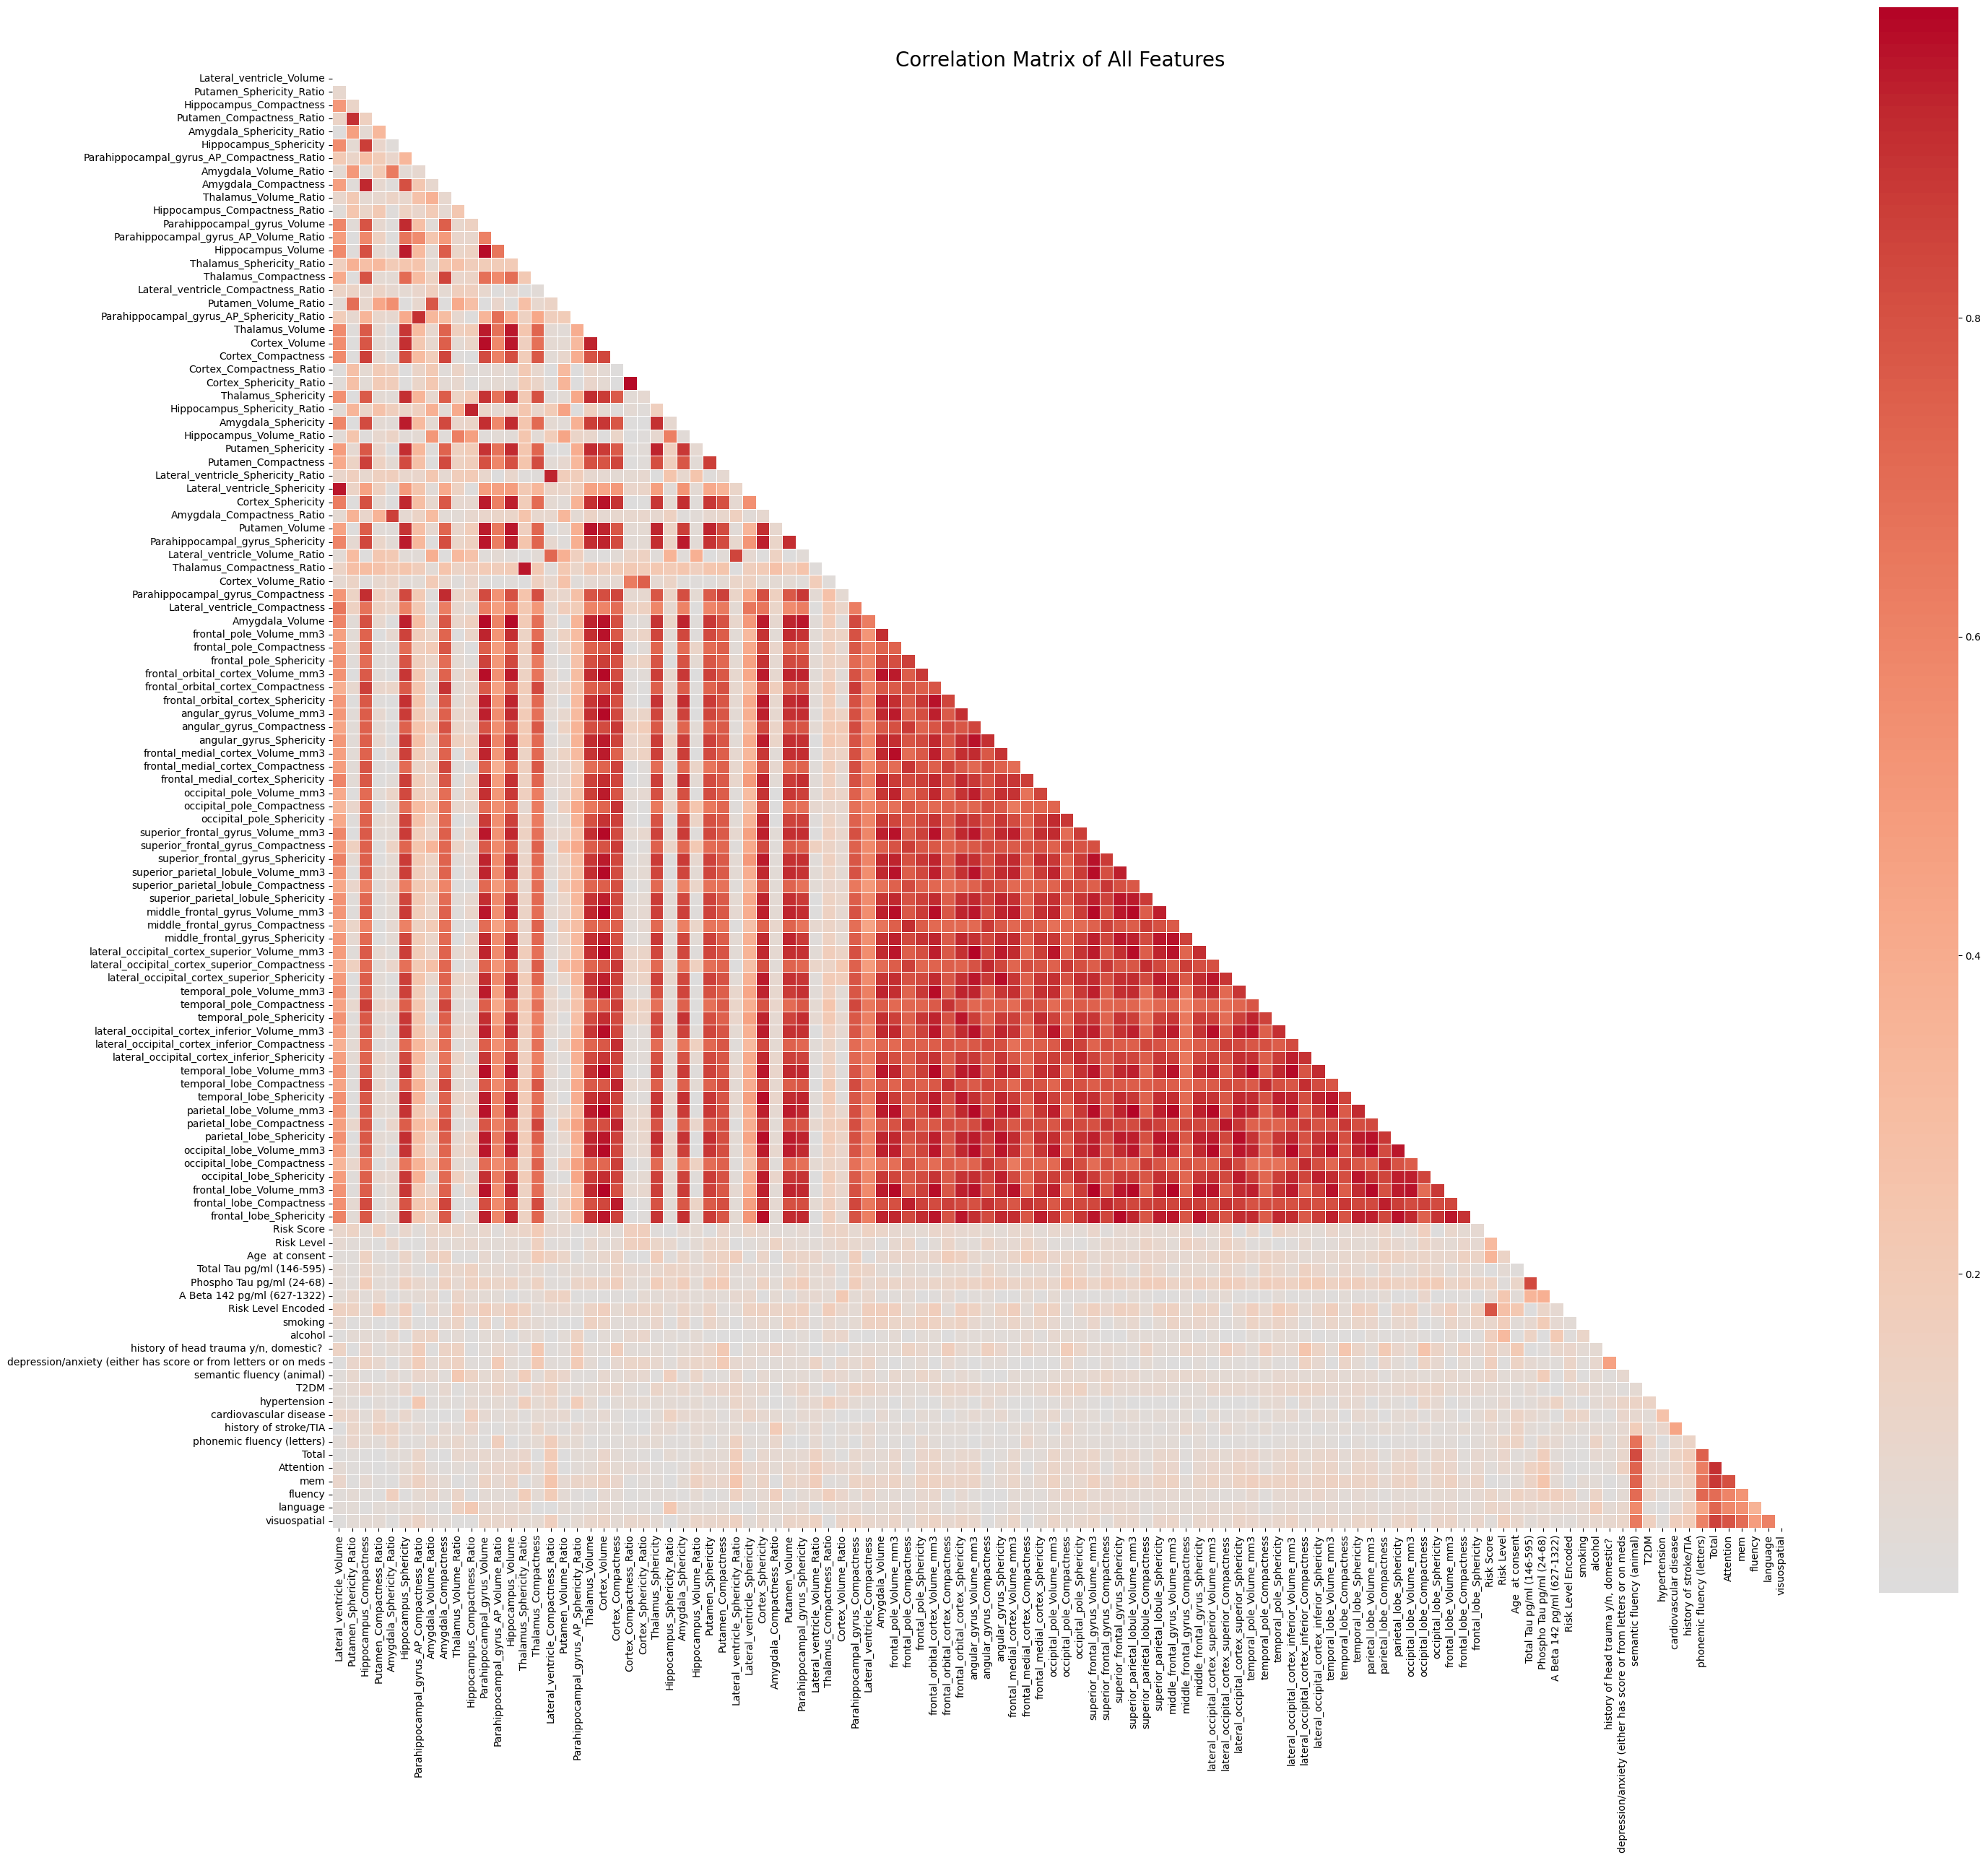


Visualizations saved:
1. selected_features_correlation_heatmap.png
2. correlation_network.png
3. vif_analysis.png
Multicollinearity analysis script is ready.


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

def analyze_multicollinearity(df, selected_features, threshold=0.9):
    """
    Comprehensive multicollinearity analysis
    
    Parameters:
    - df: DataFrame containing features
    - selected_features: List of features to analyze
    - threshold: Correlation threshold for identifying high correlation
    
    Returns:
    - Dictionary with multicollinearity analysis results
    """
    print("\n---------- MULTICOLLINEARITY ANALYSIS ----------")
    
    # Prepare correlation matrix
    selected_df = df[selected_features]
    corr_matrix = selected_df.corr().abs()
    
    # Identify highly correlated features
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] > threshold:
                col_i = corr_matrix.columns[i]
                col_j = corr_matrix.columns[j]
                corr_value = corr_matrix.iloc[i, j]
                high_corr_pairs.append((col_i, col_j, corr_value))
    
    # Print analysis results
    print(f"Number of highly correlated feature pairs (r > {threshold}): {len(high_corr_pairs)}")
    if len(high_corr_pairs) > 0:
        print("Top 10 highest correlated pairs:")
        high_corr_pairs.sort(key=lambda x: x[2], reverse=True)
        for i, (col_i, col_j, corr_value) in enumerate(high_corr_pairs[:10]):
            print(f"{col_i} - {col_j}: {corr_value:.4f}")
    
    # Visualization methods
    def create_correlation_heatmap(corr_matrix):
        """Create a detailed correlation heatmap"""
        plt.figure(figsize=(30, 30))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, 
                    mask=mask, 
                    annot=True, 
                    cmap='coolwarm', 
                    center=0,
                    square=True, 
                    linewidths=.5, 
                    cbar_kws={"shrink": .8},
                    fmt='.2f')
        plt.title('Correlation Matrix of All Features', fontsize=20)
        plt.tight_layout()
        plt.show()
    
    
    # Generate visualizations
    try:
        create_correlation_heatmap(corr_matrix)
        
        print("\nVisualizations saved:")
        print("1. selected_features_correlation_heatmap.png")
        print("2. correlation_network.png")
        print("3. vif_analysis.png")
    except Exception as e:
        print(f"Visualization generation error: {e}")
    
    # Return analysis results
    return {
        "high_correlation_pairs": high_corr_pairs,
    }

# Example usage
def main():
    # Assuming X is your DataFrame and selected_features is your list of features
    # Replace these with your actual data
    selected_features = X.columns.tolist()
    print(len(X.columns.tolist()))
    
    # Perform multicollinearity analysis
    results = analyze_multicollinearity(X, selected_features)

if __name__ == "__main__":
    main()

print("Multicollinearity analysis script is ready.")


---------- MULTICOLLINEARITY ANALYSIS ----------
Number of highly correlated feature pairs (r > 0.9): 587
Top 10 highest correlated pairs:
frontal_lobe_Volume_mm3 - middle_frontal_gyrus_Volume_mm3: 0.9951
frontal_lobe_Volume_mm3 - Cortex_Volume: 0.9922
parietal_lobe_Volume_mm3 - Cortex_Volume: 0.9920
frontal_lobe_Volume_mm3 - superior_frontal_gyrus_Volume_mm3: 0.9897
middle_frontal_gyrus_Volume_mm3 - Cortex_Volume: 0.9887
lateral_occipital_cortex_superior_Volume_mm3 - angular_gyrus_Volume_mm3: 0.9884
parietal_lobe_Volume_mm3 - superior_parietal_lobule_Volume_mm3: 0.9880
frontal_lobe_Volume_mm3 - parietal_lobe_Volume_mm3: 0.9868
frontal_lobe_Volume_mm3 - frontal_pole_Volume_mm3: 0.9868
parietal_lobe_Volume_mm3 - lateral_occipital_cortex_superior_Volume_mm3: 0.9867
Correlation heatmap saved as 'selected_features_correlation.png'


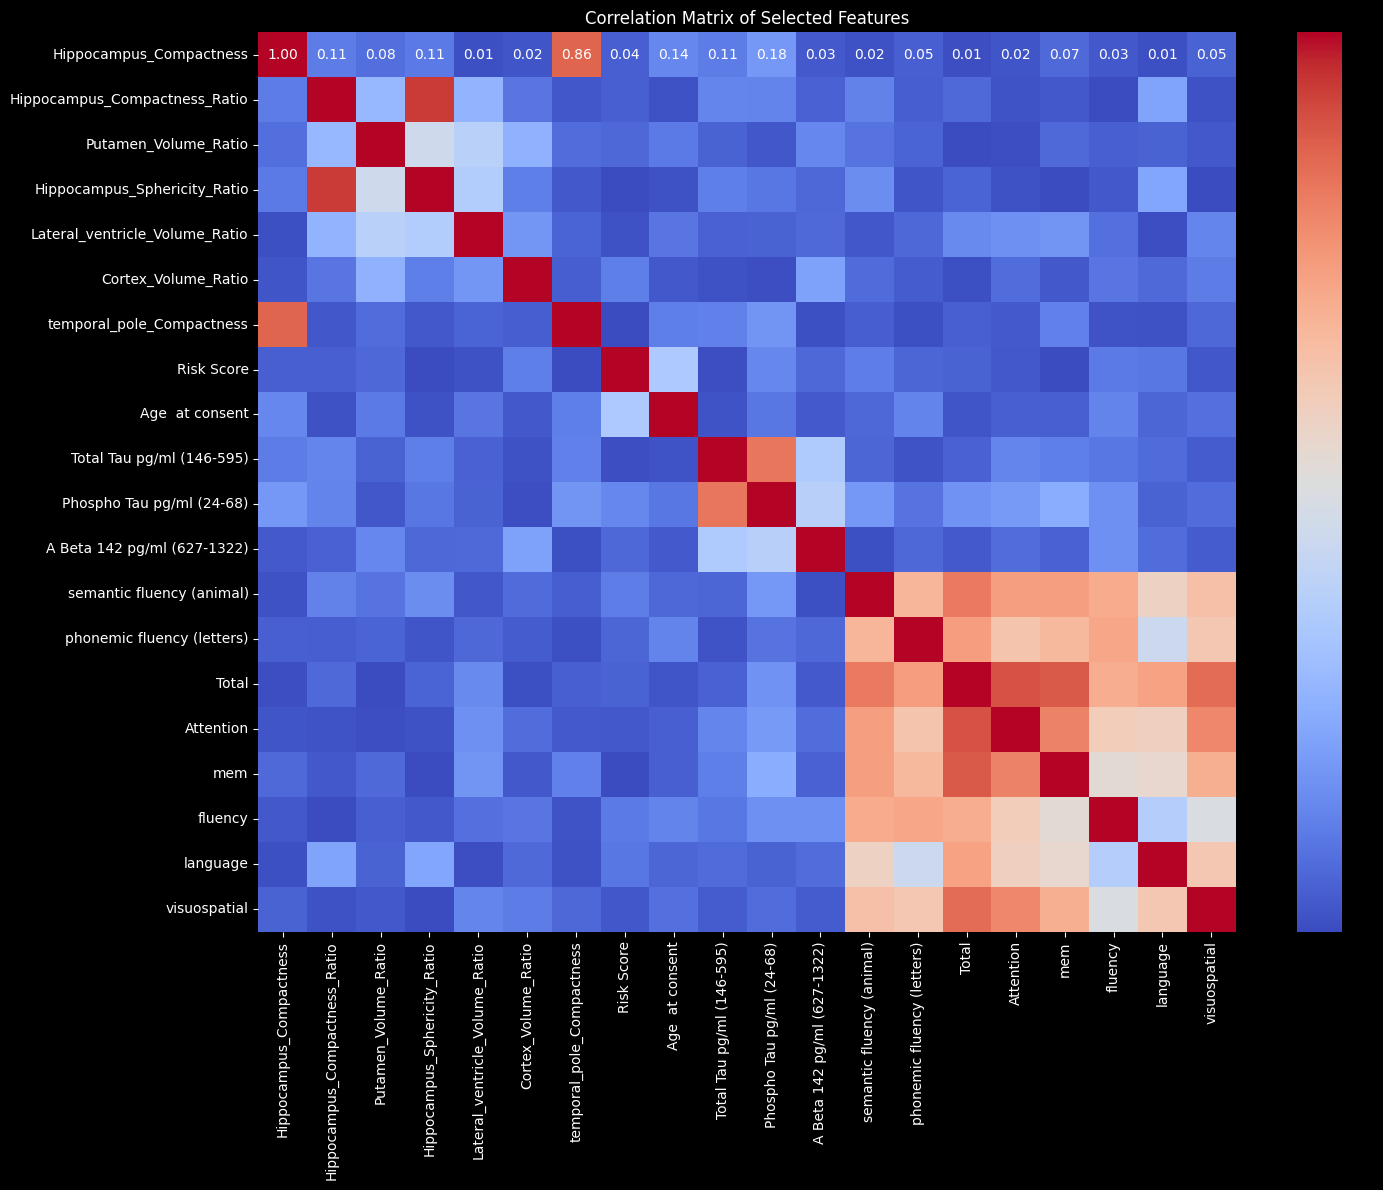

In [25]:
print("\n---------- MULTICOLLINEARITY ANALYSIS ----------")
# Calculate correlation matrix for original features
corr_matrix = X.corr().abs()
selected_features = list(selected_features_rfe)
# Additional features for classes with less instances
# additional_features = ['superior_parietal_lobule_Volume_mm3', 'parietal_lobe_Volume_mm3', 'superior_frontal_gyrus_Volume_mm3', 'middle_frontal_gyrus_Volume_mm3', 'frontal_orbital_cortex_Volume_mm3', 'frontal_lobe_Volume_mm3']
# selected_features.extend(additional_features)
# Identify highly correlated features
threshold = 0.9
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > threshold:
            col_i = corr_matrix.columns[i]
            col_j = corr_matrix.columns[j]
            corr_value = corr_matrix.iloc[i, j]
            high_corr_pairs.append((col_i, col_j, corr_value))

print(f"Number of highly correlated feature pairs (r > {threshold}): {len(high_corr_pairs)}")
if len(high_corr_pairs) > 0:
    print("Top 10 highest correlated pairs:")
    high_corr_pairs.sort(key=lambda x: x[2], reverse=True)
    for i, (col_i, col_j, corr_value) in enumerate(high_corr_pairs[:10]):
        print(f"{col_i} - {col_j}: {corr_value:.4f}")

# Save correlation heatmap of selected features (optional)
# Comment out if you don't need the visualization
try:
    fig = plt.figure(figsize=(15, 12))
    fig.set_facecolor('black')
    ax=fig.subplots()
    ax.tick_params(colors='white', which='both')
    plt.rc_context({'axes.edgecolor':'orange', 'xtick.color':'red', 'ytick.color':'green', 'figure.facecolor':'white'})
    selected_features_list = list(selected_features)
    selected_corr = df[selected_features_list].corr().abs()
    sns.heatmap(selected_corr, annot=True, cmap='coolwarm', fmt='.2f', 
                xticklabels=selected_features_list, yticklabels=selected_features_list)
    plt.title('Correlation Matrix of Selected Features')
    plt.tight_layout()
    plt.savefig('selected_features_correlation.png')
    print("Correlation heatmap saved as 'selected_features_correlation.png'")
except Exception as e:
    print(f"Could not generate correlation heatmap: {e}")

In [13]:
print("\n---------- GROUP-BASED FEATURE SELECTION ----------")
# Group features by brain region
region_groups = {}
for col in X.columns:
    parts = col.split('_')
    if len(parts) >= 2:
        # Extract brain region by removing the measurement type and unit
        if parts[-1] in ['mm3', 'mm2']:
            region = '_'.join(parts[:-2])
        else:
            region = '_'.join(parts[:-1])
        
        if region not in region_groups:
            region_groups[region] = []
        region_groups[region].append(col)

# Find top 5 most important brain regions based on average feature importance
region_importance = {}
region_top_features = {}

for region, columns in region_groups.items():
    # Get feature indices for this region
    region_cols_indices = [list(X.columns).index(col) for col in columns]
    
    # Calculate region importance
    region_importance[region] = np.mean([importances[i] for i in region_cols_indices])
    
    # Sort features in this region by their importance
    region_features_with_importance = [
        (X.columns[idx], importances[idx]) 
        for idx in region_cols_indices
    ]
    
    # Sort features by importance in descending order
    sorted_region_features = sorted(
        region_features_with_importance, 
        key=lambda x: x[1], 
        reverse=True
    )
    
    # Store top 3 features for each region
    region_top_features[region] = [
        feature for feature, _ in sorted_region_features[:3]
    ]

# Print top 5 most important regions
top_regions = sorted(region_importance.items(), key=lambda x: x[1], reverse=True)[:20]
print("\nTop 5 most important brain regions based on average feature importance:")
for region, importance in top_regions:
    print(f"{region}: {importance:.4f}")

# Print top 3 features for each of these top regions
selected_features_global = []
print("\nTop 3 features for top regions:")
for region, importance in top_regions:
    print(f"\n{region} (Importance: {importance:.4f}):")
    top_features = region_top_features[region]
    for feature in top_features:
        selected_features_global.append(feature)
print(len(selected_features_global))


---------- GROUP-BASED FEATURE SELECTION ----------

Top 5 most important brain regions based on average feature importance:
Cortex_Volume: 0.0222
Lateral_ventricle_Volume: 0.0139
Hippocampus_Volume: 0.0121
Cortex_Compactness: 0.0116
Parahippocampal_gyrus_AP_Sphericity: 0.0112
Cortex_Sphericity: 0.0112
Hippocampus_Compactness: 0.0112
Putamen_Sphericity: 0.0110
Hippocampus_Sphericity: 0.0108
Putamen_Volume: 0.0105
Thalamus_Sphericity: 0.0100
Thalamus_Volume: 0.0098
Parahippocampal_gyrus_AP_Compactness: 0.0095
Amygdala_Volume: 0.0094
Lateral_ventricle_Compactness: 0.0085
Putamen_Compactness: 0.0077
Thalamus_Compactness: 0.0076
Parahippocampal_gyrus_AP_Volume: 0.0075
Lateral_ventricle: 0.0070
Hippocampus: 0.0069

Top 3 features for top regions:

Cortex_Volume (Importance: 0.0222):

Lateral_ventricle_Volume (Importance: 0.0139):

Hippocampus_Volume (Importance: 0.0121):

Cortex_Compactness (Importance: 0.0116):

Parahippocampal_gyrus_AP_Sphericity (Importance: 0.0112):

Cortex_Sphericity 

In [ ]:
from diagnostic_models import build_advanced_neural_network, build_stacking_ensemble, build_knn_model, build_neural_network_model, build_random_forest_model, build_svm_model, build_xgboost_model, compare_models
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np


In [ ]:
def main(data_path, target_column, feature_columns=None, models_to_run=None, 
          test_size=0.3, use_adasyn=True, adasyn_neighbors=6, random_state=42):
    """
    Main function to run multiple classification models and compare their performance.
    
    Parameters:
    -----------
    data_path : str
        Path to the dataset file (Excel or CSV)
    target_column : str
        Column name of the target variable
    feature_columns : list, optional
        List of column names to use as features, if None will use all numeric columns
    models_to_run : list, optional
        List of model names to run. Options: 'xgboost', 'rf', 'dt', 'svm', 'nn', 'knn',
        'stack', 'bayes', 'gpc', 'gnb', 'tabnet', 'snn', 'att'.
        If None, all basic models will be run.
    test_size : float, default=0.3
        Proportion of data to use for testing
    use_adasyn : bool, default=True
        Whether to use ADASYN oversampling for imbalanced classes
    adasyn_neighbors : int, default=6
        Number of neighbors to use in ADASYN algorithm
    random_state : int, default=42
        Random seed for reproducibility
    
    Returns:
    --------
    dict
        Dictionary of model results
    pandas.DataFrame
        Comparison of model performance
    """
    # Initialize results dictionary
    models_results = {}
    
    # Set default models list if not provided
    if models_to_run is None:
        # By default, run only the basic models, not the advanced ones
        models_to_run = ['xgboost', 'rf', 'dt', 'svm', 'nn', 'knn', 'stack', 'gpc', 'gnb', 'tabnet', 'snn', 'att']
    else:
        models_to_run = [model.lower() for model in models_to_run]
    
    # Run XGBoost model
    if 'xgboost' in models_to_run:
        models_results['XGBoost'] = build_xgboost_model(
            data_path=data_path,
            target_column=target_column,
            feature_columns=feature_columns,
            test_size=test_size,
            use_adasyn=use_adasyn,
            adasyn_neighbors=adasyn_neighbors,
            random_state=random_state
        )
    
    # Run Random Forest model
    if 'rf' in models_to_run:
        models_results['RandomForest'] = build_random_forest_model(
            data_path=data_path,
            target_column=target_column,
            feature_columns=feature_columns,
            test_size=test_size,
            use_adasyn=use_adasyn,
            adasyn_neighbors=adasyn_neighbors,
            random_state=random_state
        )
    
    # Run SVM model
    if 'svm' in models_to_run:
        models_results['SVM'] = build_svm_model(
            data_path=data_path,
            target_column=target_column,
            feature_columns=feature_columns,
            test_size=test_size,
            use_adasyn=use_adasyn,
            adasyn_neighbors=adasyn_neighbors,
            random_state=random_state
        )
    
    # Run Neural Network model
    if 'nn' in models_to_run:
        models_results['NeuralNetwork'] = build_neural_network_model(
            data_path=data_path,
            target_column=target_column,
            feature_columns=feature_columns,
            test_size=test_size,
            use_adasyn=use_adasyn,
            adasyn_neighbors=adasyn_neighbors,
            random_state=random_state
        )
    
    # Run KNN model
    if 'knn' in models_to_run:
        models_results['KNN'] = build_knn_model(
            data_path=data_path,
            target_column=target_column,
            feature_columns=feature_columns,
            test_size=test_size,
            use_adasyn=use_adasyn,
            adasyn_neighbors=adasyn_neighbors,
            random_state=random_state
        )
    
    # Run Stacking Ensemble model
    if 'stack' in models_to_run:
        models_results['StackingEnsemble'] = build_stacking_ensemble(
            data_path=data_path,
            target_column=target_column,
            feature_columns=feature_columns,
            test_size=test_size,
            use_adasyn=use_adasyn,
            adasyn_neighbors=adasyn_neighbors,
            random_state=random_state
        )
    
    # Run Advanced Neural Network (Self-Normalizing Neural Network)
    if 'snn' in models_to_run:
        models_results['SelfNormalizingNN'] = build_advanced_neural_network(
            data_path=data_path,
            target_column=target_column,
            feature_columns=feature_columns,
            nn_type='snn',
            test_size=test_size,
            use_adasyn=use_adasyn,
            adasyn_neighbors=adasyn_neighbors,
            model_name="SelfNormalizingNN",
            random_state=random_state
        )
    
    # Run Advanced Neural Network (Attention-based)
    if 'att' in models_to_run:
        models_results['AttentionNN'] = build_advanced_neural_network(
            data_path=data_path,
            target_column=target_column,
            feature_columns=feature_columns,
            nn_type='att',
            test_size=test_size,
            use_adasyn=use_adasyn,
            adasyn_neighbors=adasyn_neighbors,
            model_name="AttentionNN",
            random_state=random_state
        )
    
    # Compare models if more than one model was run
    if len(models_results) > 1:
        # Compare by accuracy
        comparison_acc = compare_models(models_results, metric='accuracy')
        print("\nModel Comparison (Accuracy):")
        print(comparison_acc)
        
        # Compare by ROC AUC
        comparison_roc = compare_models(models_results, metric='roc_auc')
        print("\nModel Comparison (ROC AUC):")
        print(comparison_roc)
        
        return models_results, comparison_acc
    elif len(models_results) == 1:
        print("\nOnly one model was run, no comparison performed.")
        return models_results, None
    else:
        print("\nNo models were run.")
        return {}, None


Building XGBoost Model
Loaded data with 180 rows and 115 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 144, Test set size: 36
Class distribution in training set: [75  6  3  9  8  3  7  7  3 12  3  8]
Detected class imbalance (ratio: 25.00). Trying ADASYN.
ADASYN failed: Not any neigbours belong to the majority class. This case will induce a NaN case with a division by zero. ADASYN is not suited for this specific dataset. Use SMOTE instead.
Trying SMOTE as fallback...
After SMOTE - Training set size: 647
Class distribution after SMOTE: [75 52 52 52 52 52 52 52 52 52 52 52]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.992) total time=   0.3s
[CV] END ................................ score: (test=0.969) total time=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] END ................................ score: (test=0.992) total time=   0.1s
[CV] END ................................ score: (test=0.984) total time=   0.1s
[CV] END ................................ score: (test=1.000) total time=   0.1s
Cross-validation accuracy (default params): 0.9877 ± 0.0104

Performing hyperparameter tuning...
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished


Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Best cross-validation score: 0.9892

Training final model with best parameters...

Test Set Performance:
Accuracy: 0.8889
ROC AUC: 0.9869

Confusion Matrix:
[[18  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  2]]

Classification Report:
                          precision    recall  f1-score   support

                      AD       0.95      0.95      0.95        19
                     CBD       1.00      1.00      1.00         1
       

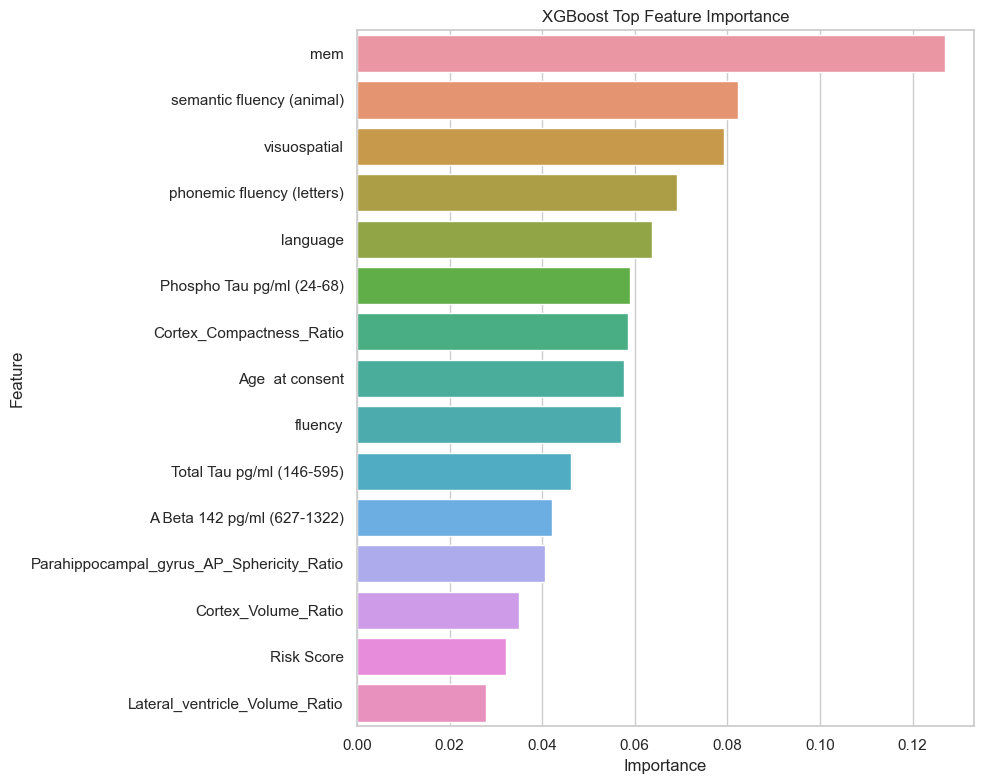

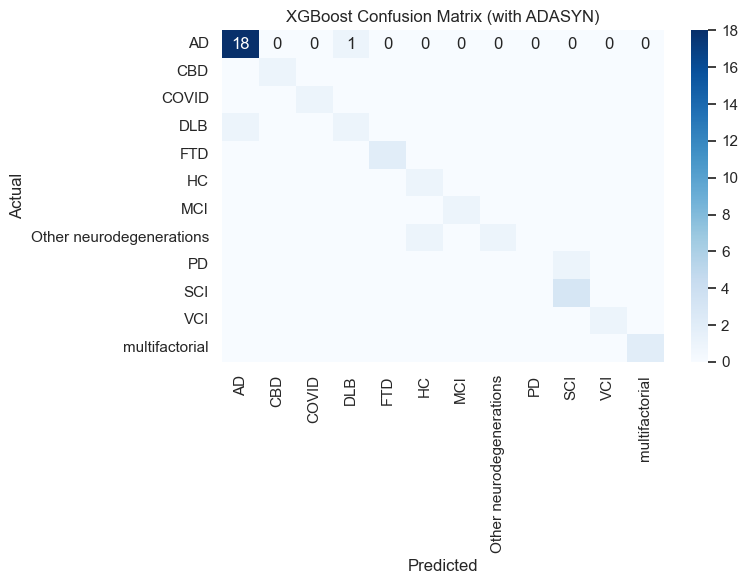

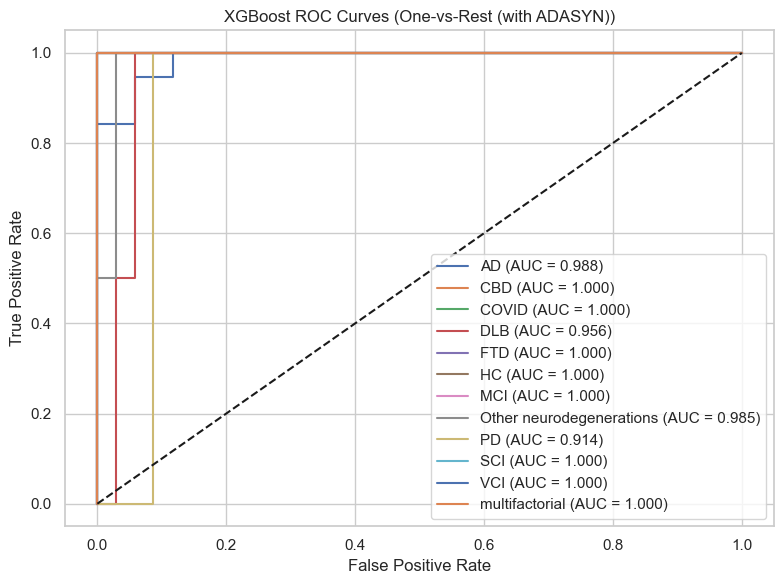

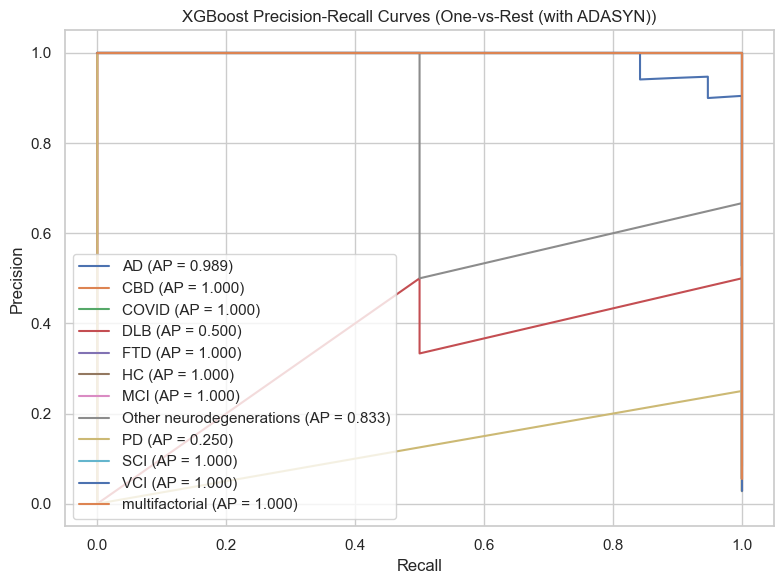


XGBoost model training and evaluation complete.

Building RandomForest Model
Loaded data with 180 rows and 115 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 144, Test set size: 36
Class distribution in training set: [75  6  3  9  8  3  7  7  3 12  3  8]
Detected class imbalance (ratio: 25.00). Trying ADASYN.
ADASYN failed: Not any neigbours belong to the majority class. This case will induce a NaN case with a division by zero. ADASYN is not suited for this specific dataset. Use SMOTE instead.
Trying SMOTE as fallback...
After SMOTE - Training set size: 647
Class distribution after SMOTE: [75 52 52 52 52 52 52 52 52 52 52 52]
Cross-validation accuracy (default params): 0.9923 ± 0.0049

Performing hyperparameter tuning...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'bootstrap': False, 'max_depth': None, 'min_

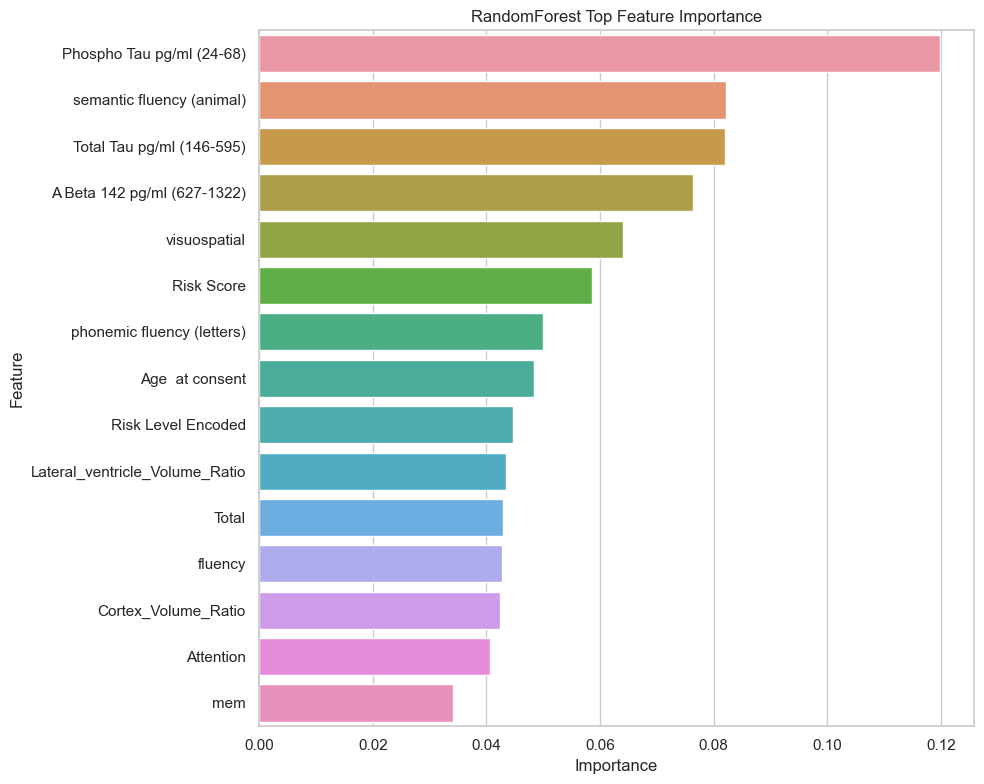

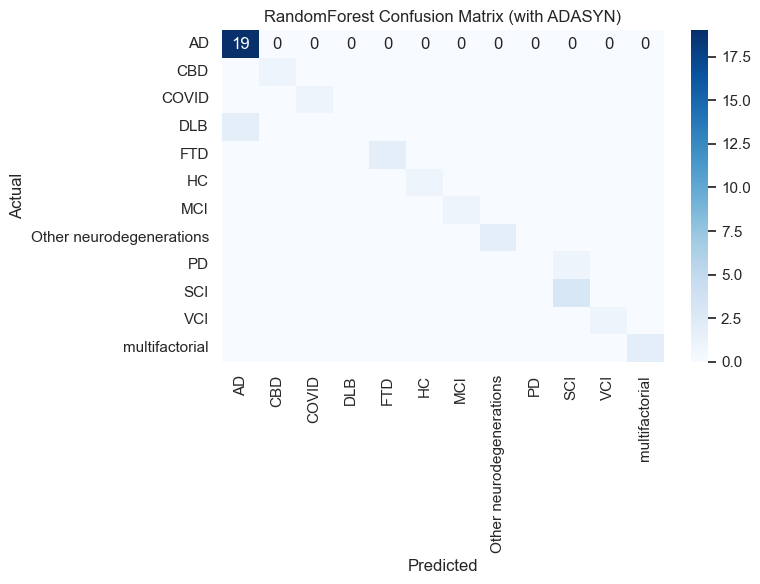

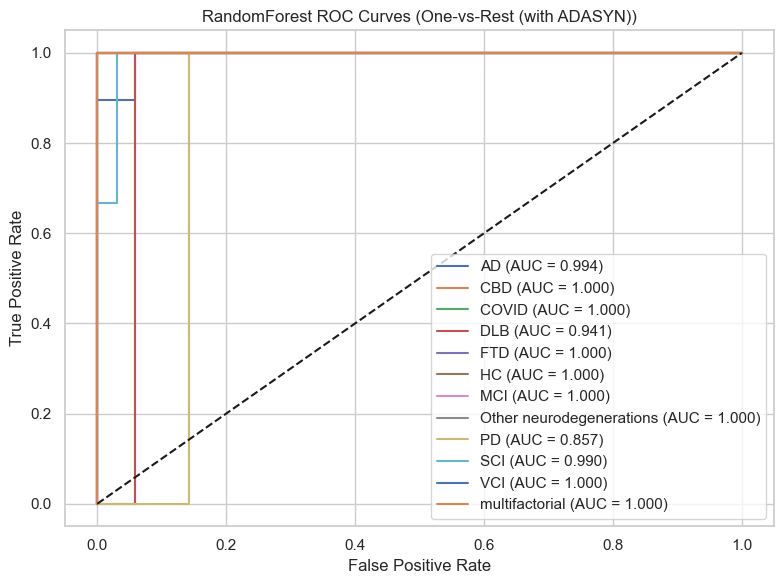

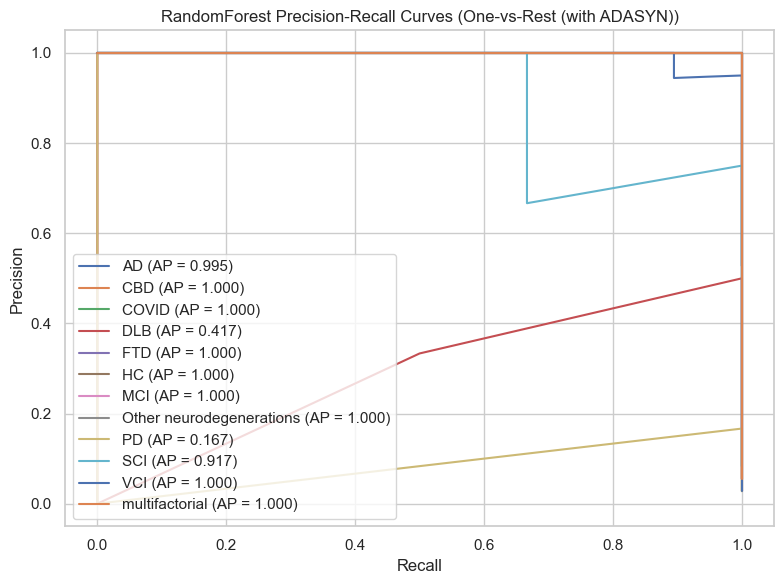


RandomForest model training and evaluation complete.

Building DecisionTree Model
Loaded data with 180 rows and 115 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 144, Test set size: 36
Class distribution in training set: [75  6  3  9  8  3  7  7  3 12  3  8]
Detected class imbalance (ratio: 25.00). Trying ADASYN.
ADASYN failed: Not any neigbours belong to the majority class. This case will induce a NaN case with a division by zero. ADASYN is not suited for this specific dataset. Use SMOTE instead.
Trying SMOTE as fallback...
After SMOTE - Training set size: 647
Class distribution after SMOTE: [75 52 52 52 52 52 52 52 52 52 52 52]
Cross-validation accuracy (default params): 0.9398 ± 0.0197

Performing hyperparameter tuning...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters: {'criterion': 'entropy', 'max_depth': No

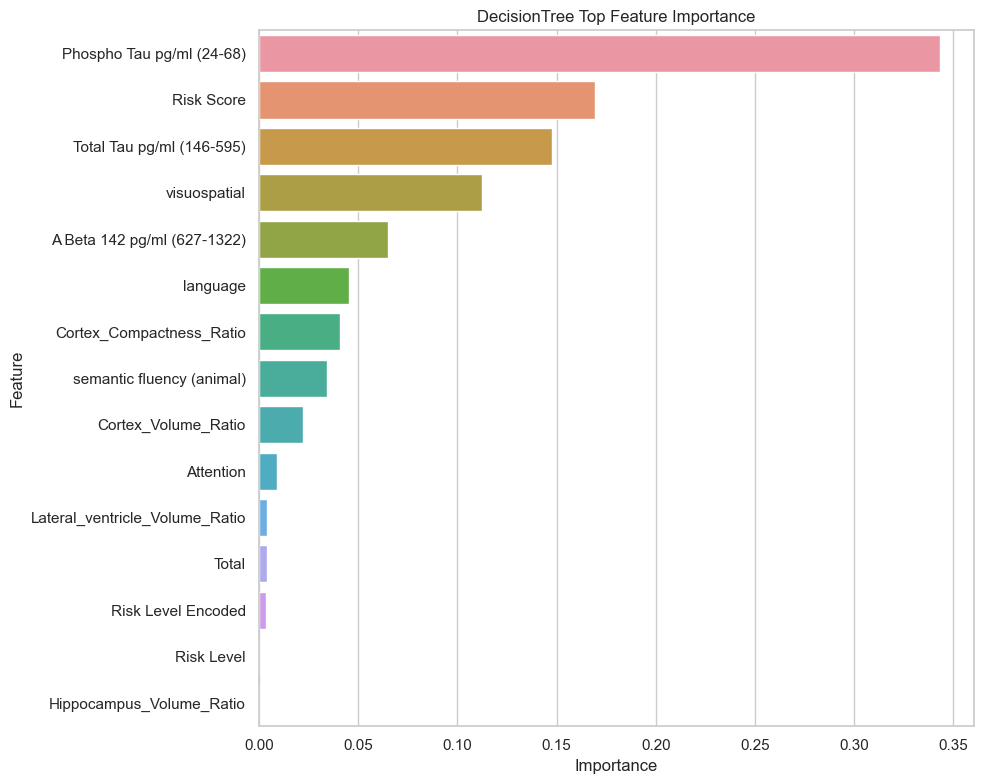

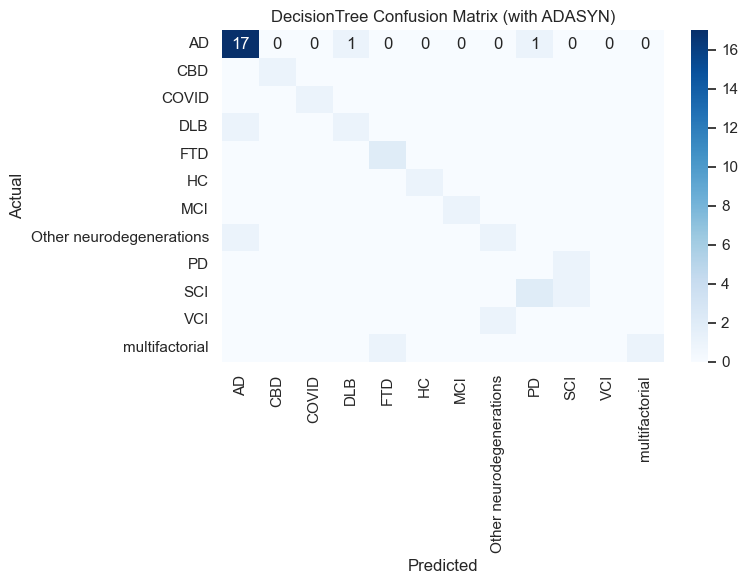

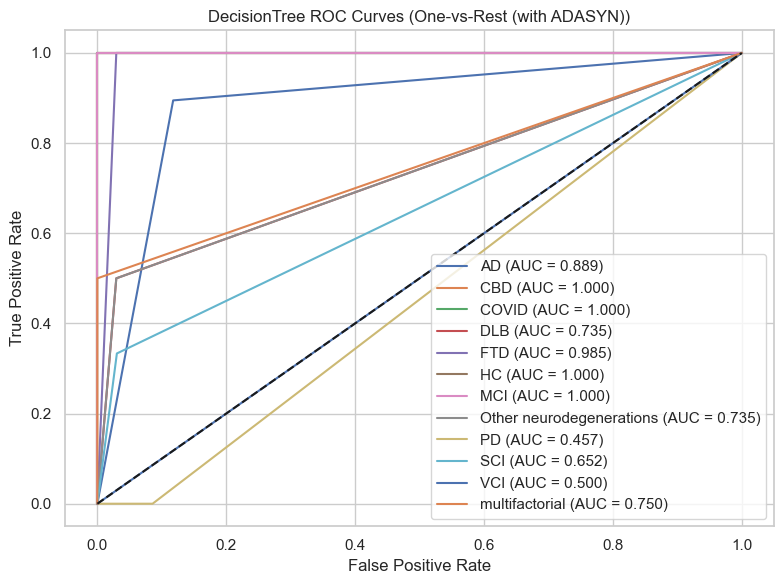

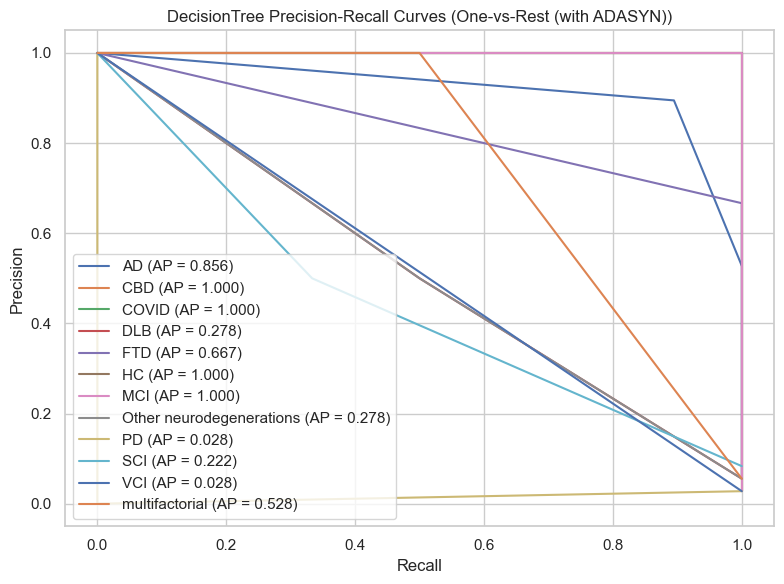


DecisionTree model training and evaluation complete.

Building SVM Model
Loaded data with 180 rows and 115 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 144, Test set size: 36
Class distribution in training set: [75  6  3  9  8  3  7  7  3 12  3  8]
Detected class imbalance (ratio: 25.00). Trying ADASYN.
ADASYN failed: Not any neigbours belong to the majority class. This case will induce a NaN case with a division by zero. ADASYN is not suited for this specific dataset. Use SMOTE instead.
Trying SMOTE as fallback...
After SMOTE - Training set size: 647
Class distribution after SMOTE: [75 52 52 52 52 52 52 52 52 52 52 52]
Cross-validation accuracy (default params): 0.9784 ± 0.0114

Performing hyperparameter tuning...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf', 'probabi

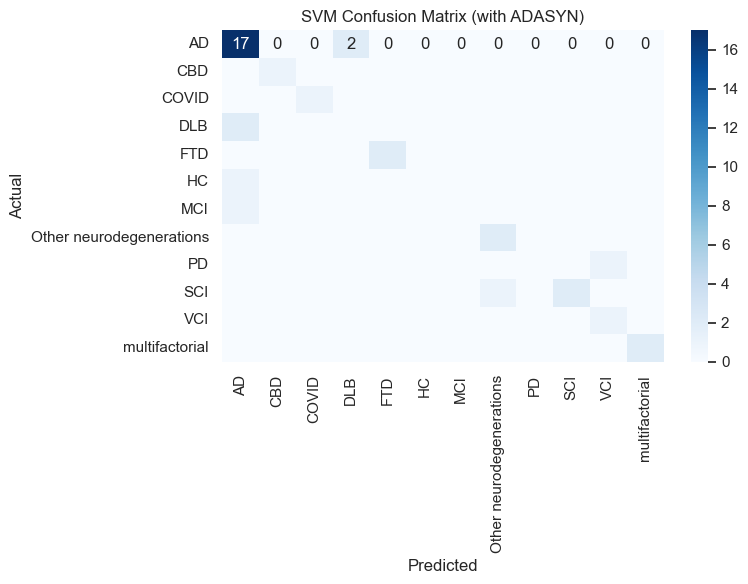

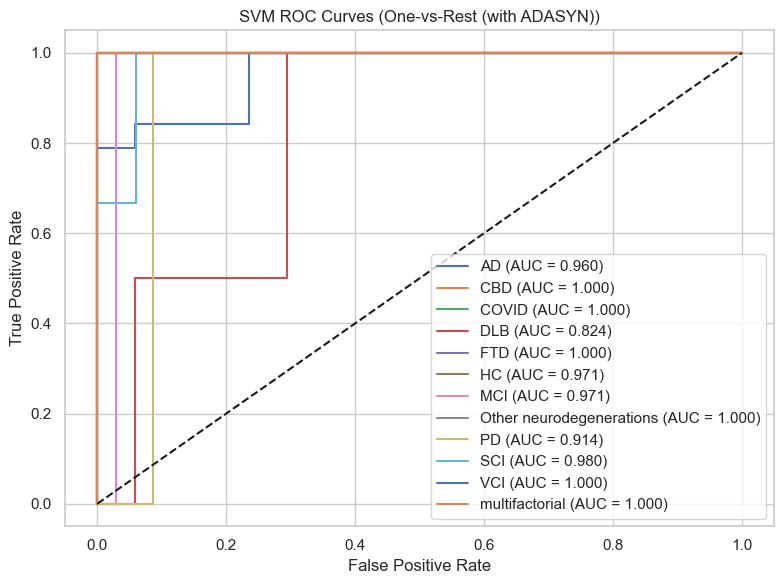

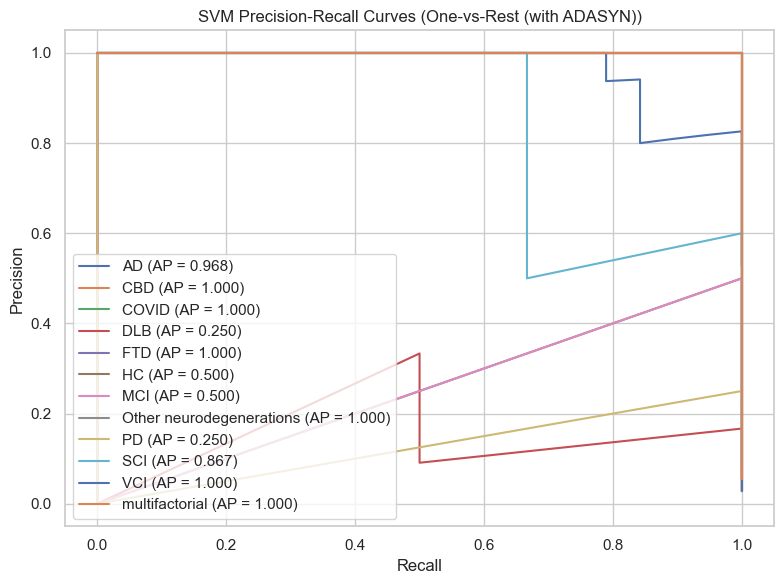


SVM model training and evaluation complete.

Building NeuralNetwork Model
Loaded data with 180 rows and 115 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 144, Test set size: 36
Class distribution in training set: [75  6  3  9  8  3  7  7  3 12  3  8]
Detected class imbalance (ratio: 25.00). Trying ADASYN.
ADASYN failed: Not any neigbours belong to the majority class. This case will induce a NaN case with a division by zero. ADASYN is not suited for this specific dataset. Use SMOTE instead.
Trying SMOTE as fallback...
After SMOTE - Training set size: 647
Class distribution after SMOTE: [75 52 52 52 52 52 52 52 52 52 52 52]
Cross-validation accuracy (default params): 0.8642 ± 0.0659

Performing hyperparameter tuning...
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_

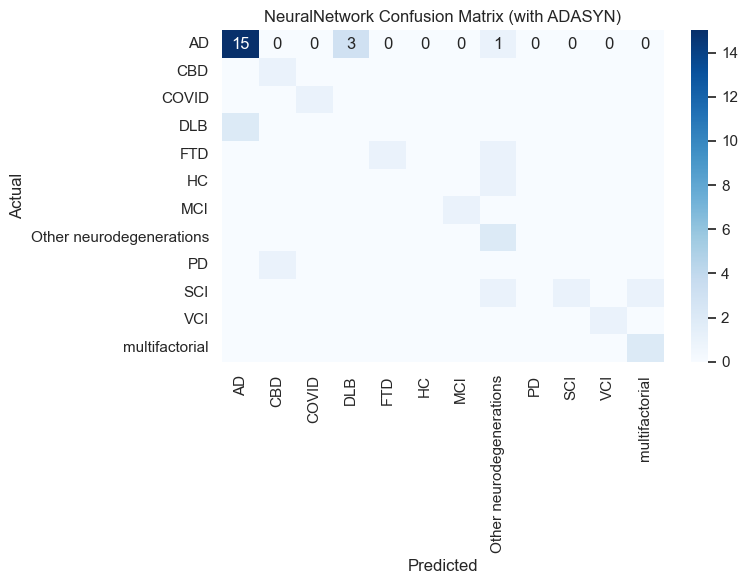

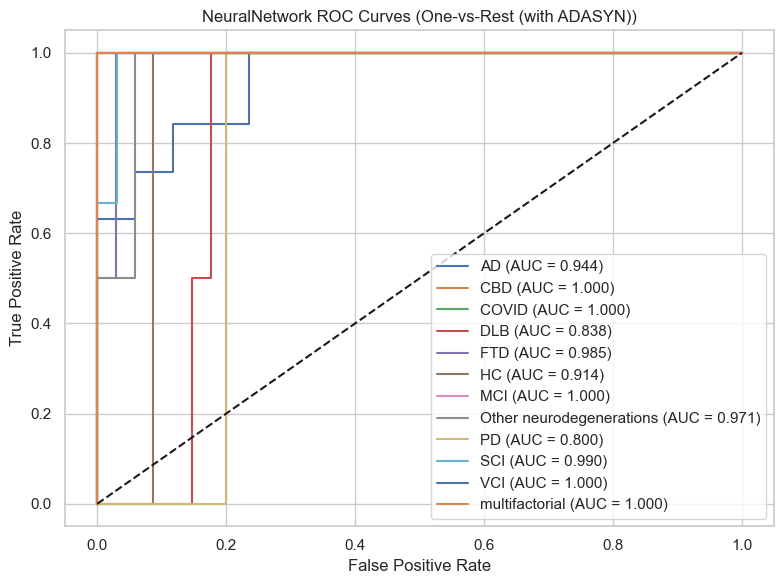

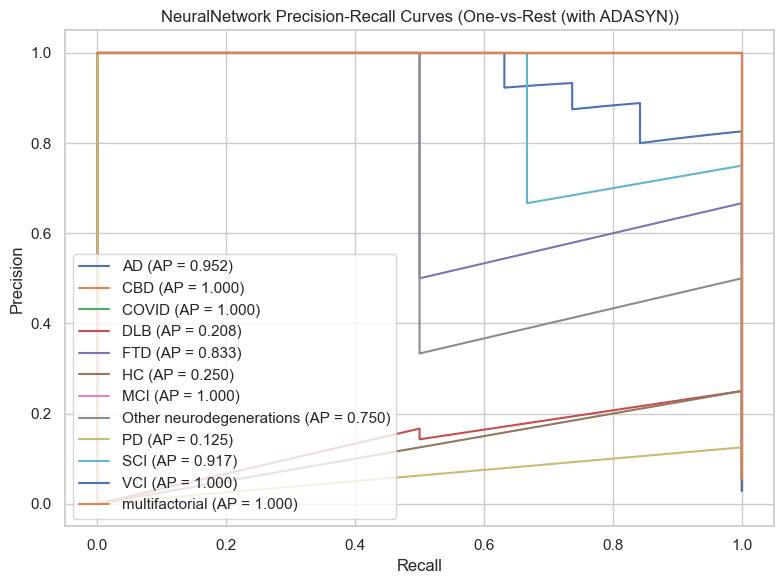


NeuralNetwork model training and evaluation complete.

Building KNN Model
Loaded data with 180 rows and 115 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 144, Test set size: 36
Class distribution in training set: [75  6  3  9  8  3  7  7  3 12  3  8]
Detected class imbalance (ratio: 25.00). Trying ADASYN.
ADASYN failed: Not any neigbours belong to the majority class. This case will induce a NaN case with a division by zero. ADASYN is not suited for this specific dataset. Use SMOTE instead.
Trying SMOTE as fallback...
After SMOTE - Training set size: 647
Class distribution after SMOTE: [75 52 52 52 52 52 52 52 52 52 52 52]
Cross-validation accuracy (default params): 0.9460 ± 0.0252

Performing hyperparameter tuning...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'p': 1

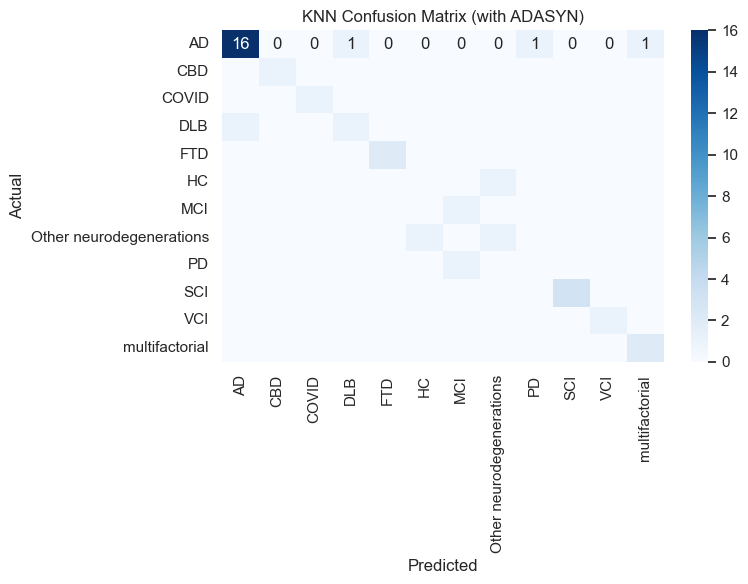

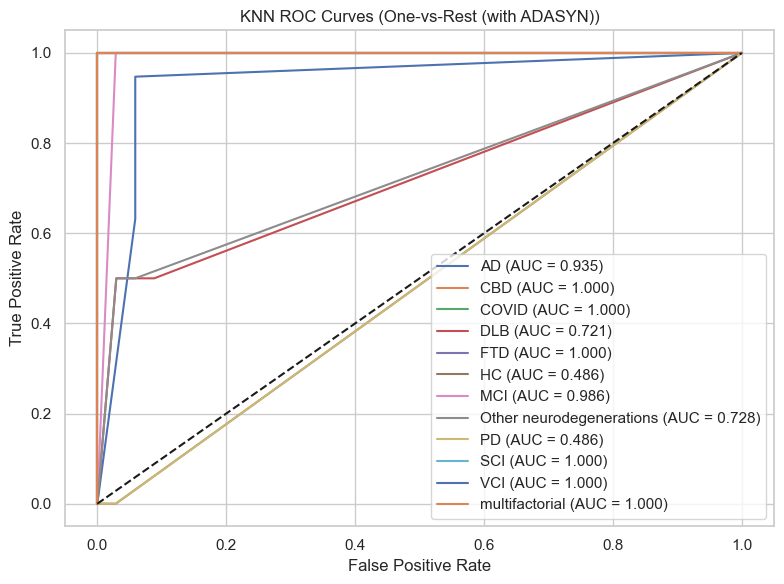

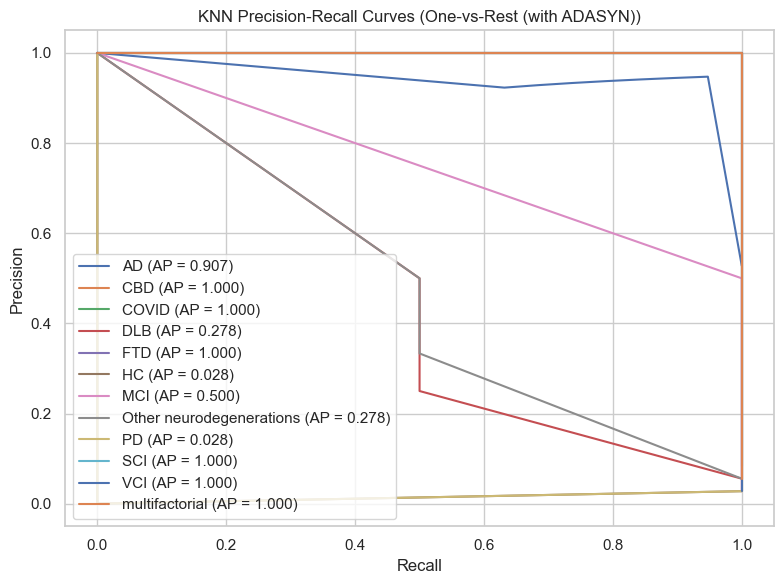


KNN model training and evaluation complete.

Building StackingEnsemble Model
Loaded data with 180 rows and 115 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 144, Test set size: 36
Class distribution in training set: [75  6  3  9  8  3  7  7  3 12  3  8]
Detected class imbalance (ratio: 25.00). Trying ADASYN.
ADASYN failed: Not any neigbours belong to the majority class. This case will induce a NaN case with a division by zero. ADASYN is not suited for this specific dataset. Use SMOTE instead.
Trying SMOTE as fallback...
After SMOTE - Training set size: 647
Class distribution after SMOTE: [75 52 52 52 52 52 52 52 52 52 52 52]
Cross-validation accuracy: 0.9923 ± 0.0084

Training final stacking ensemble model...

Test Set Performance:
Accuracy: 0.8889
ROC AUC: 0.9742

Confusion Matrix:
[[19  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  

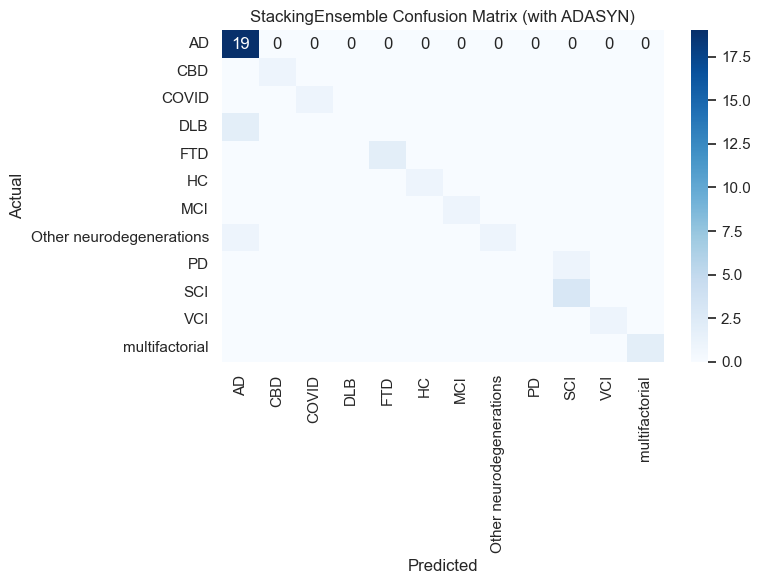

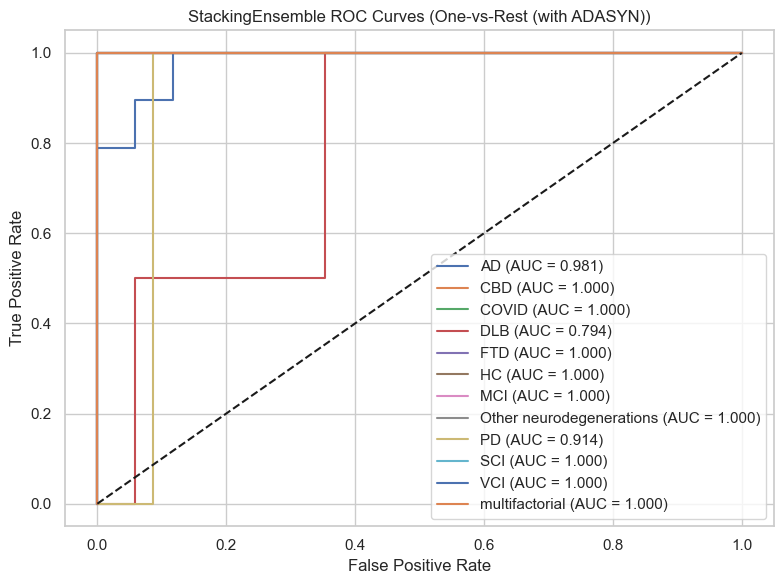

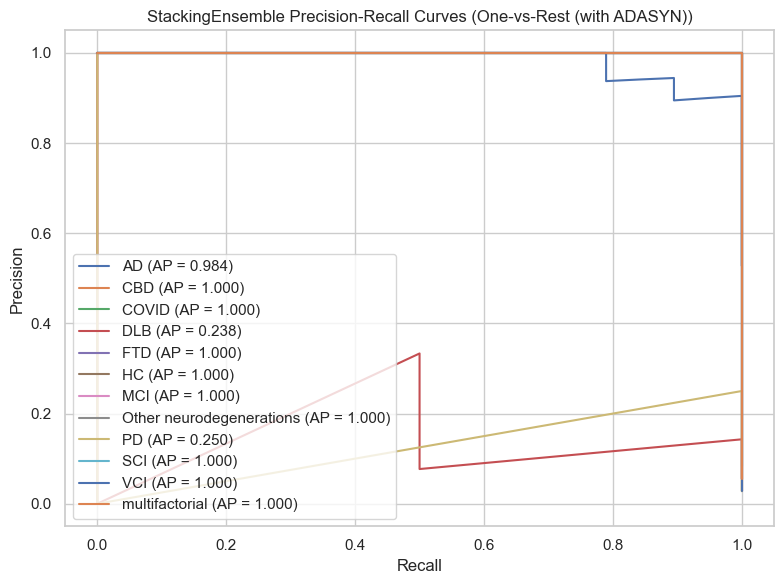


StackingEnsemble model training and evaluation complete.

Building GaussianNaiveBayes Model
Loaded data with 180 rows and 115 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 144, Test set size: 36
Class distribution in training set: [75  6  3  9  8  3  7  7  3 12  3  8]
Detected class imbalance (ratio: 25.00). Trying ADASYN.
ADASYN failed: Not any neigbours belong to the majority class. This case will induce a NaN case with a division by zero. ADASYN is not suited for this specific dataset. Use SMOTE instead.
Trying SMOTE as fallback...
After SMOTE - Training set size: 647
Class distribution after SMOTE: [75 52 52 52 52 52 52 52 52 52 52 52]
Cross-validation accuracy (default params): 0.9428 ± 0.0159

Performing hyperparameter tuning...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'var_smoothing': 1e-09}
Best cr

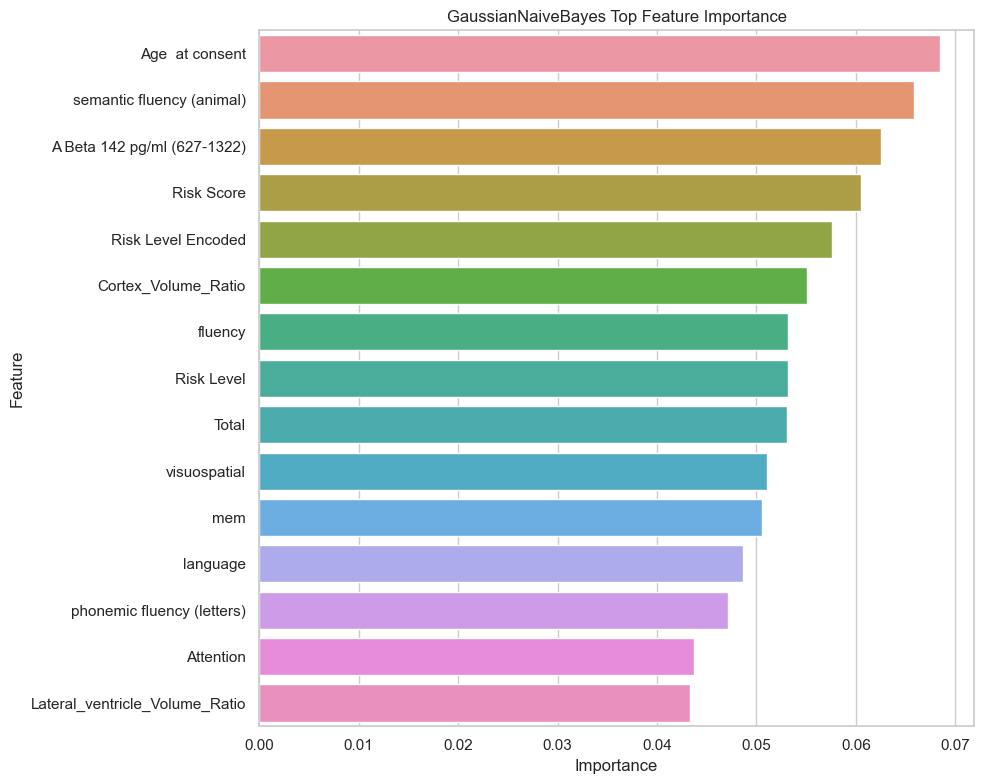

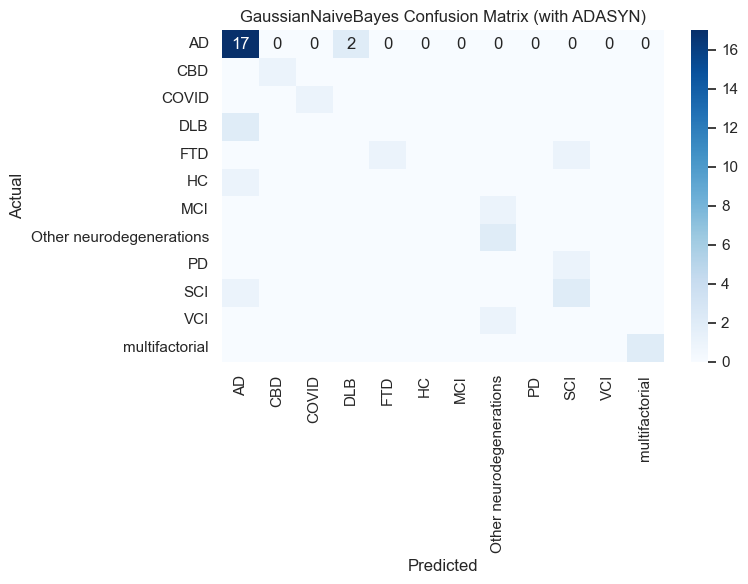

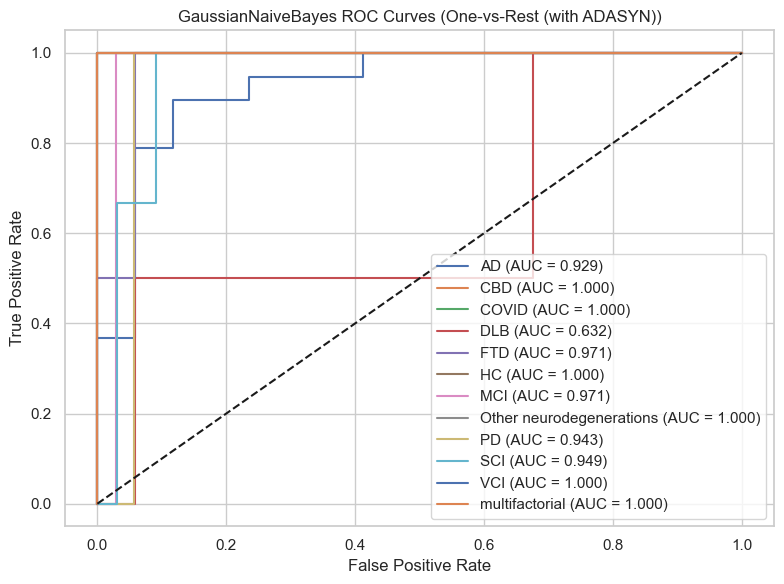

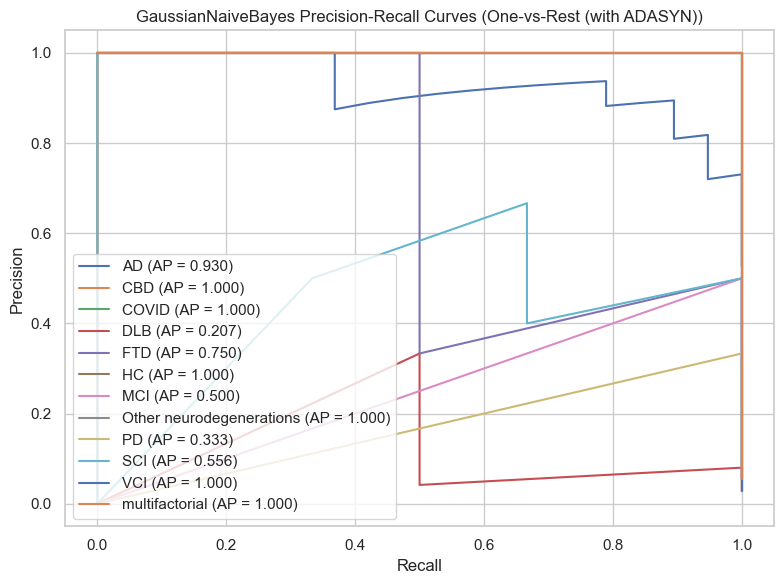


GaussianNaiveBayes model training and evaluation complete.

Building SelfNormalizingNN (SNN) Model with PyTorch
Using device: cpu
Loaded data with 180 rows and 115 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 144, Test set size: 36
Class distribution in training set: [75  6  3  9  8  3  7  7  3 12  3  8]
Detected class imbalance (ratio: 25.00). Trying ADASYN.
ADASYN failed: Not any neigbours belong to the majority class. This case will induce a NaN case with a division by zero. ADASYN is not suited for this specific dataset. Use SMOTE instead.
Trying SMOTE as fallback...
After SMOTE - Training set size: 647
Class distribution after SMOTE: [75 52 52 52 52 52 52 52 52 52 52 52]

Training PyTorch model with early stopping...
Epoch 10/200, Train Loss: 0.8132, Val Loss: 0.5656
Epoch 20/200, Train Loss: 0.3464, Val Loss: 0.1928
Epoch 30/200, Train

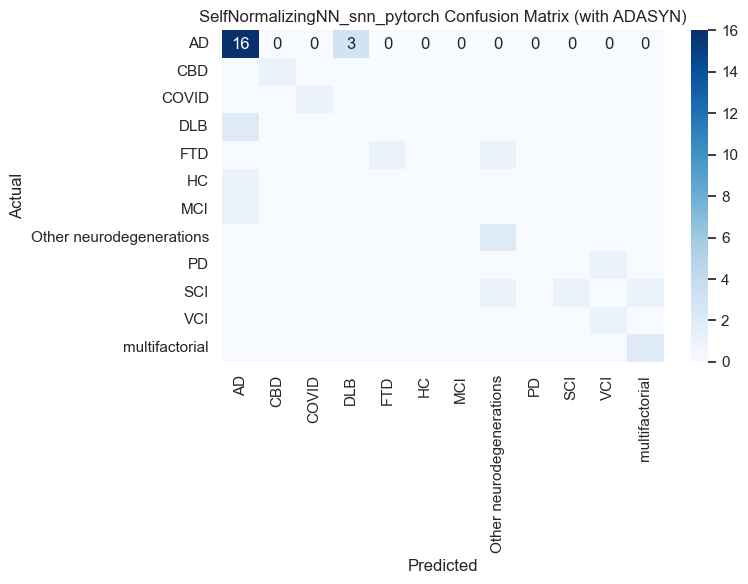

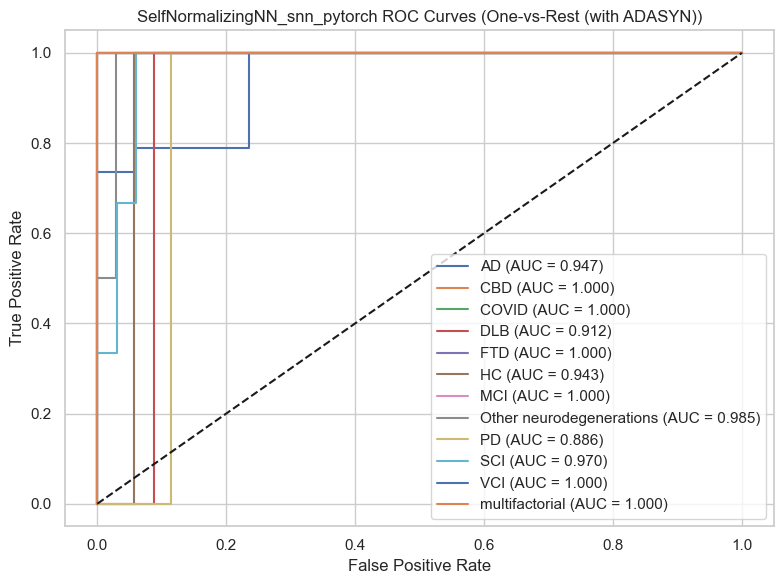

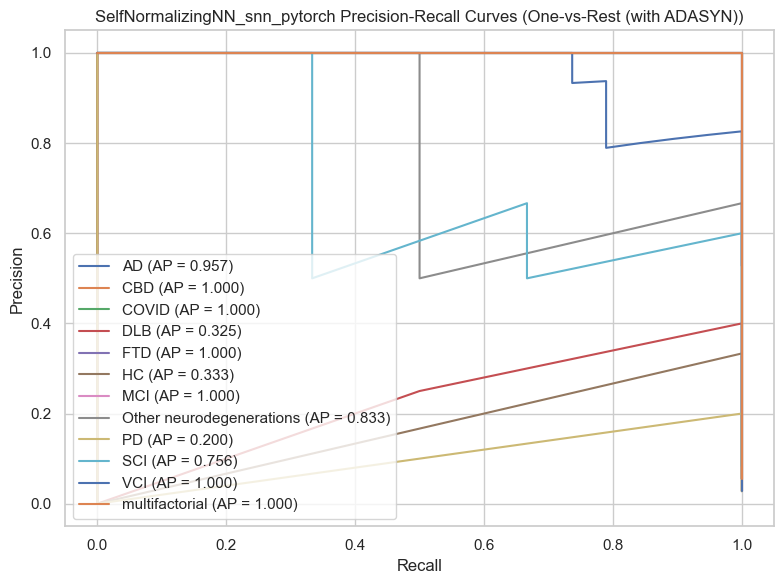

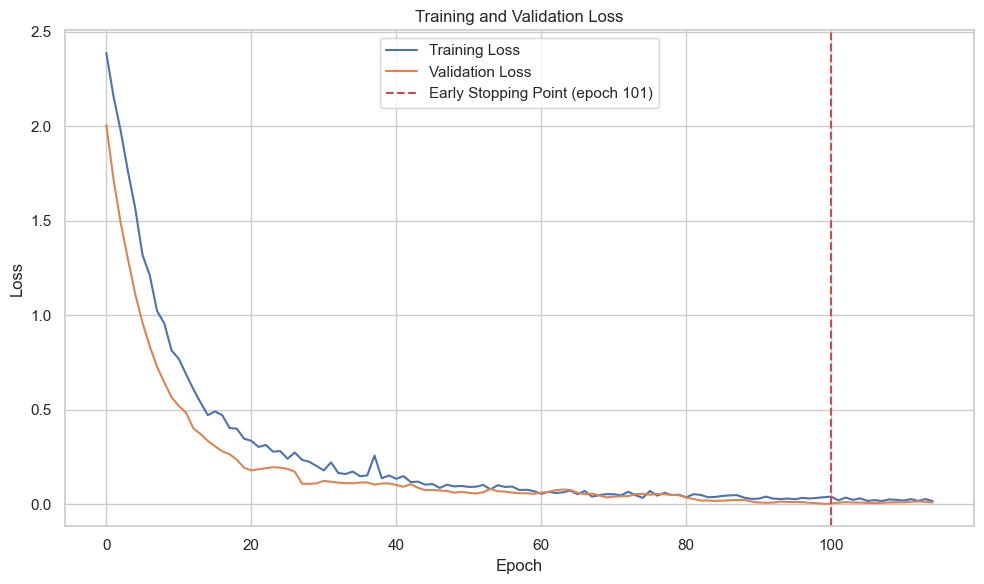


SelfNormalizingNN (snn) PyTorch model training and evaluation complete.

Building AttentionNN (ATT) Model with PyTorch
Using device: cpu
Loaded data with 180 rows and 115 columns
Encoding categorical target: Completed Diagnosis
Classes: ['AD' 'CBD' 'COVID' 'DLB' 'FTD' 'HC' 'MCI' 'Other neurodegenerations' 'PD'
 'SCI' 'VCI' 'multifactorial']
Training set size: 144, Test set size: 36
Class distribution in training set: [75  6  3  9  8  3  7  7  3 12  3  8]
Detected class imbalance (ratio: 25.00). Trying ADASYN.
ADASYN failed: Not any neigbours belong to the majority class. This case will induce a NaN case with a division by zero. ADASYN is not suited for this specific dataset. Use SMOTE instead.
Trying SMOTE as fallback...
After SMOTE - Training set size: 647
Class distribution after SMOTE: [75 52 52 52 52 52 52 52 52 52 52 52]

Training PyTorch model with early stopping...
Epoch 10/200, Train Loss: 1.8827, Val Loss: 1.8777
Epoch 20/200, Train Loss: 1.5099, Val Loss: 1.4459
Epoch 30/200

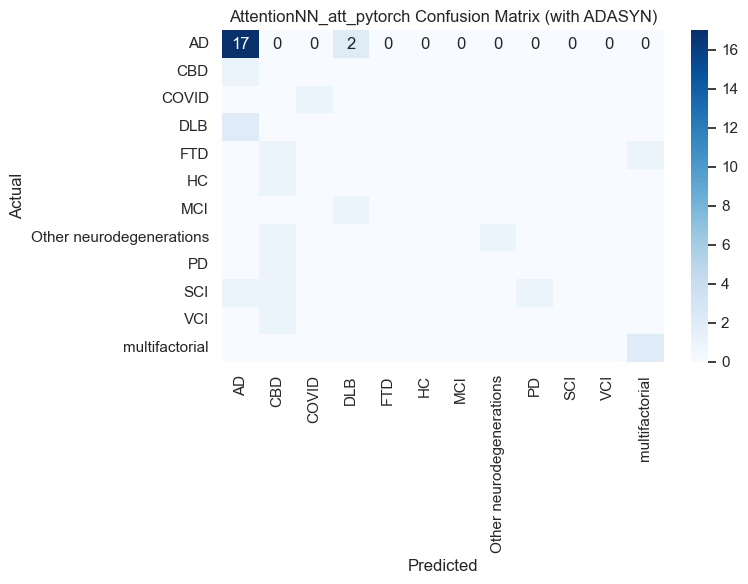

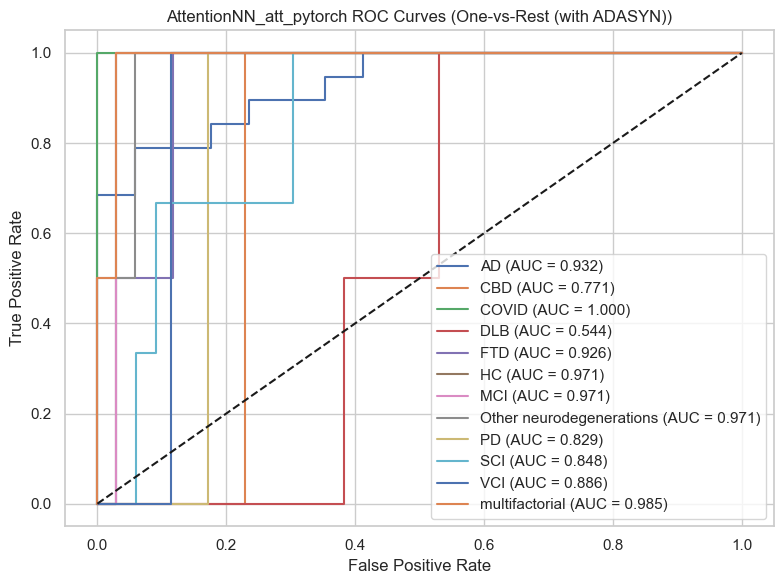

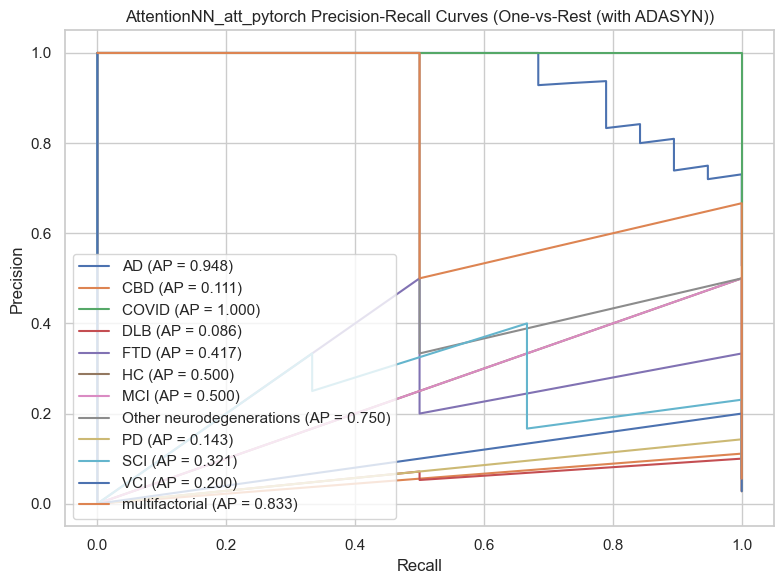

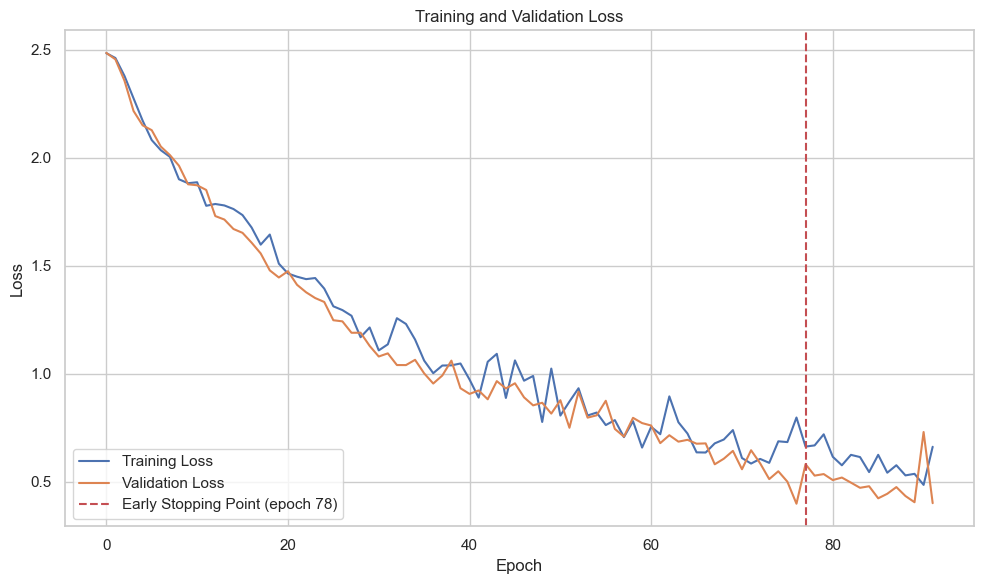


AttentionNN (att) PyTorch model training and evaluation complete.

Model Comparison (Accuracy):
                Model  Accuracy   ROC_AUC
1        RandomForest  0.916667  0.981836
0             XGBoost  0.888889  0.986923
6    StackingEnsemble  0.888889  0.974152
5                 KNN  0.805556  0.861721
3                 SVM  0.777778  0.968352
2        DecisionTree  0.750000  0.808590
7  GaussianNaiveBayes  0.722222  0.949626
4       NeuralNetwork  0.694444  0.953548
8   SelfNormalizingNN  0.694444  0.970225
9         AttentionNN  0.583333  0.886285

Model Comparison (ROC AUC):
                Model  Accuracy   ROC_AUC
0             XGBoost  0.888889  0.986923
1        RandomForest  0.916667  0.981836
6    StackingEnsemble  0.888889  0.974152
8   SelfNormalizingNN  0.694444  0.970225
3                 SVM  0.777778  0.968352
4       NeuralNetwork  0.694444  0.953548
7  GaussianNaiveBayes  0.722222  0.949626
9         AttentionNN  0.583333  0.886285
5                 KNN  0.805556  0

In [17]:
selected_features = list(top_rf_features)

if __name__ == "__main__":
    # Path to your imputed data
    data_path = "cognid_merged_data_clean.xlsx"

    # Target column (diagnosis classification)
    target_column = 'Completed Diagnosis'
    
    # Features to use (these should match the imputed columns)
    
    feature_columns = selected_features
    
    # Run all models and get comparison
    models_results, comparison = main(
        data_path=data_path,
        target_column=target_column,
        feature_columns=feature_columns,
        models_to_run=['xgboost', 'rf', 'dt', 'svm', 'nn', 'knn', 'stack', 'gnb', 'snn', 'att'],  # Run all models
        test_size=0.2,
        use_adasyn=True,
        adasyn_neighbors=5,
        random_state=42
    )
    print(len(models_results))
    
    # Alternatively, run only specific models
    # models_results, comparison = main(
    #     data_path=data_path,
    #     target_column=target_column,
    #     feature_columns=feature_columns,
    #     models_to_run=['xgboost', 'rf'],  # Only run XGBoost and Random Forest
    #     test_size=0.3,
    #     use_adasyn=True,
    #     random_state=42
    # )



In [13]:
print(selected_features_rfe)

Index(['Hippocampus_Compactness', 'Hippocampus_Compactness_Ratio',
       'Putamen_Volume_Ratio', 'Hippocampus_Sphericity_Ratio',
       'Lateral_ventricle_Volume_Ratio', 'Cortex_Volume_Ratio',
       'temporal_pole_Compactness', 'Risk Score', 'Age  at consent',
       'Total Tau pg/ml (146-595)', 'Phospho Tau pg/ml (24-68)',
       'A Beta 142 pg/ml (627-1322)', 'semantic fluency (animal)',
       'phonemic fluency (letters)', 'Total', 'Attention', 'mem', 'fluency',
       'language', 'visuospatial'],
      dtype='object')
